In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install plotnine xgboost Prophet optuna shap xgboost



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322

In [ ]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from plotnine import *


import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'


from IPython.core.debugger import set_trace

In [ ]:

from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [ ]:
# !git config --global user.name "Praveen Kumar Anwla"
# !git config --global user.email "praveenkumar.kumar76@gmail.com"

In [ ]:
!git clone https://github.com/Praveen76/MMM-using-Non-linear-models-and-SHAP-Values

Cloning into 'MMM-using-Non-linear-models-and-SHAP-Values'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 43 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 10.24 MiB | 8.67 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
%cd MMM-using-Non-linear-models-and-SHAP-Values

/content/MMM-using-Non-linear-models-and-SHAP-Values


In [ ]:
import shap
shap.initjs()

In [ ]:
from prophet import Prophet

from functools import partial
import optuna as opt

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


In [ ]:
START_ANALYSIS_INDEX = 52
END_ANALYSIS_INDEX = 144

In [ ]:
data_org = pd.read_csv("./MMM_data.csv", parse_dates = ["DATE"])
data_org.columns = [c.lower() if c in ["DATE"] else c for c in data_org.columns]
data_org


,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000


In [ ]:
# Import holidays dataset from prophet
holidays = pd.read_csv("./prophet_holidays_daily.csv", parse_dates = ["ds"])

holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time

# #combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_us = holidays_weekly.query("(country == 'US')").copy()
holidays_weekly_us

,ds,holiday,country,year
53,1994-12-26,New Year's Day,US,1995
80,1995-01-02,New Year's Day (Observed),US,1995
89,1995-01-16,Martin Luther King Jr. Day,US,1995
120,1995-02-20,Washington's Birthday,US,1995
382,1995-05-29,Memorial Day,US,1995
...,...,...,...,...
35665,2044-10-10,Columbus Day,US,2044
35720,2044-11-07,Veterans Day,US,2044
35740,2044-11-21,Thanksgiving,US,2044
35821,2044-12-19,Christmas Day,US,2044


In [ ]:
data_org.events.unique()

array(['na', 'event1', 'event2'], dtype=object)

In [ ]:
df = data_org.rename(columns = {'revenue': 'y', 'date': 'ds'})

#add categorical into prophet
df = pd.concat([df, pd.get_dummies(df["events"], drop_first = True, prefix = "events")], axis = 1)
df

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385,False,True
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000,False,True
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000,False,True
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000,False,True
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000,False,True
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000,False,True
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000,False,True
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000,False,True


In [ ]:
# Model should include yearly seasonality in the forecast with holiday effects being included in the model, and the holidays are provided in the holidays_weekly_us dataset.
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_us)

#A regressor named "events_event2" is added to the model. This regressor contains additional information or events that might impact the time series.
prophet.add_regressor(name = "events_event2")

#A regressor named "events_na" is added to the model. This regressor contains additional information or events that might impact the time series.
prophet.add_regressor(name = "events_na")

In [ ]:
# Train the prophet model using date column called ds, target variable called 'y', and additional features/regressors like events_event2 & events_na
prophet.fit(df[["ds", "y", "events_event2", "events_na"]])
prophet_prediction = prophet.predict(df[["ds", "y", "events_event2", "events_na"]])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp911mx5zp/lmc2z53l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp911mx5zp/pdaa1uo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48699', 'data', 'file=/tmp/tmp911mx5zp/lmc2z53l.json', 'init=/tmp/tmp911mx5zp/pdaa1uo3.json', 'output', 'file=/tmp/tmp911mx5zp/prophet_modelmo_2ni3n/prophet_model-20250817200157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:01:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:01:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


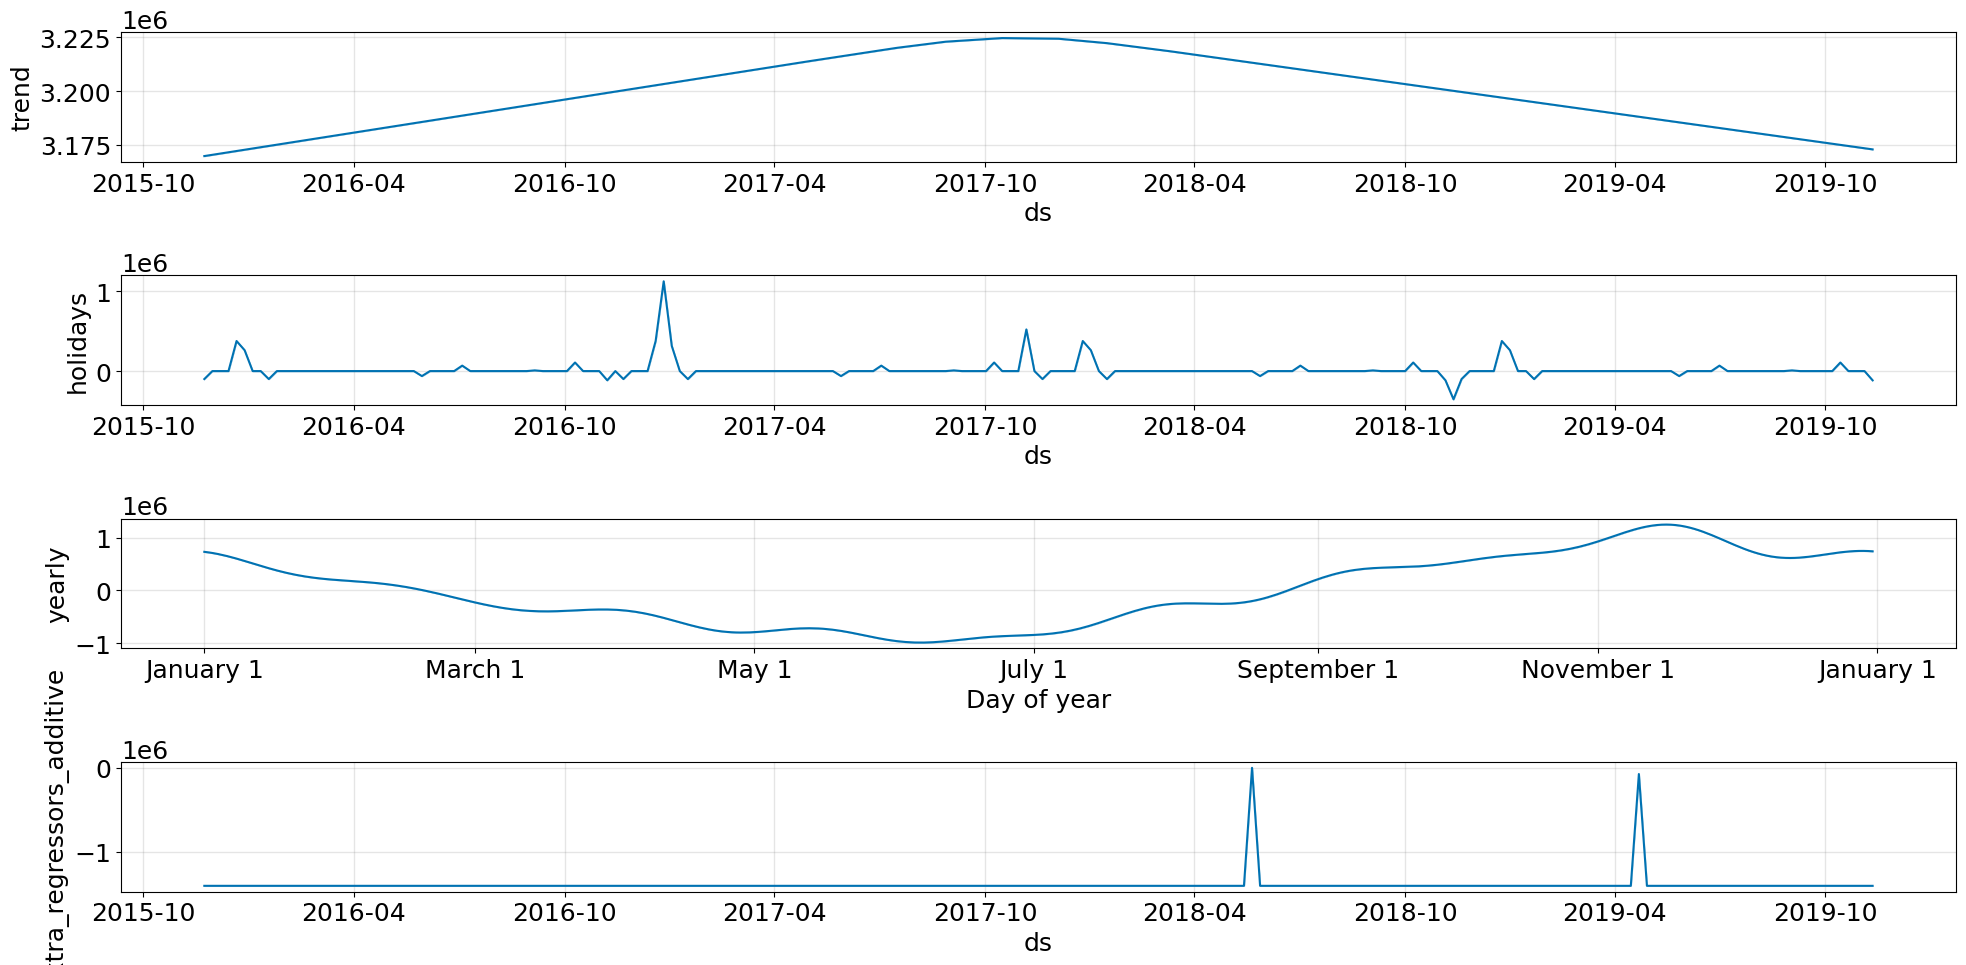

In [ ]:
plot = prophet.plot_components(prophet_prediction, figsize = (20, 10))


In [ ]:
# Let's understand above 4 separate plots showing different aspects of the data:

# - The 1st plot shows the trend component, indicating a general increase in values over time with some seasonality.
# - The 2nd plot shows holidays from 2015 to 2019
# - The 3rd plot illustrates yearly seasonality, capturing patterns that repeat annually.
# - The 4th plot represents an additive regression component, highlighting specific points in time where significant changes occurred.

# The blue line in each plot represents the model prediction, and the shaded area represents the uncertainty interval.
# The x-axis is the date (ds), ranging from October 2015 to October 2019.
# The y-axis varies depending on the plot: it is labeled as "trend", "holidays", "yearly", or "multiplicative/additive" respectively.

# The above charts can help you understand how the model decomposes the time series data into different components, and how confident it is about its predictions.
#  You can also use the chart to compare the model predictions with the actual data, and evaluate the model performance.


In [ ]:
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-11-23,3169718.58528,2494658.32700,3150983.07360,3169718.58528,3169718.58528,0.00000,0.00000,0.00000,0.00000,...,-99865.73808,-99865.73808,-99865.73808,1157984.72199,1157984.72199,1157984.72199,0.00000,0.00000,0.00000,2825369.17335
1,2015-11-30,3170307.96604,2356047.60351,2982583.37468,3170307.96604,3170307.96604,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,915479.19554,915479.19554,915479.19554,0.00000,0.00000,0.00000,2683318.76574
2,2015-12-07,3170897.34680,2142313.60351,2784830.09768,3170897.34680,3170897.34680,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,689869.16314,689869.16314,689869.16314,0.00000,0.00000,0.00000,2458298.11410
3,2015-12-14,3171486.72756,2065255.75873,2695371.56066,3171486.72756,3171486.72756,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,616959.10935,616959.10935,616959.10935,0.00000,0.00000,0.00000,2385977.44107
4,2015-12-21,3172076.10832,2521089.45391,3129757.92163,3172076.10832,3172076.10832,376583.56877,376583.56877,376583.56877,0.00000,...,376583.56877,376583.56877,376583.56877,681289.95983,681289.95983,681289.95983,0.00000,0.00000,0.00000,2827481.24108


In [ ]:
# Filter out columns whose names end with "upper" or "lower," because these columns represent upper and lower bounds of prediction intervals.
prophet_columns = [col for col in prophet_prediction.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]

# keep only the columns with names containing "events_", and sum the values across columns for these events_ columns.
events_nums = prophet_prediction[prophet_columns].filter(like = "events_").sum(axis = 1)

new_data = data_org.copy()
new_data["trend"] = prophet_prediction["trend"]
new_data["season"] = prophet_prediction["yearly"]
new_data["holiday"] = prophet_prediction["holidays"]
new_data["events"] = (events_nums - np.min(events_nums)).values  # Scale events_nums values

In [ ]:
new_data.head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,trend,season,holiday
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,0.00000,19401.65385,3169718.58528,1157984.72199,-99865.73808
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,0.00000,14791.00000,3170307.96604,915479.19554,0.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,0.00000,14544.00000,3170897.34680,689869.16314,0.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,0.00000,2800.00000,3171486.72756,616959.10935,0.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,0.00000,15478.00000,3172076.10832,681289.95983,376583.56877


In [ ]:
data_org.iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
52,2016-11-21,2964696.66667,52177.90000,271909,54698.00000,80485549.89262,0.00000,0,9029457,200462.81552,na,19401.65385
53,2016-11-28,2848525.00000,0.00000,0,31072.00000,53736753.49765,73955.95632,71500,9334174,141956.39115,na,27941.00000
54,2016-12-05,2740160.00000,106908.00000,448276,0.00000,21469926.03224,65123.98793,63000,8234498,49694.03594,na,51273.00000
55,2016-12-12,2380508.33333,0.00000,0,0.00000,29472934.60218,52768.86061,55100,7904539,90910.83720,na,19606.00000
56,2016-12-19,2230915.00000,0.00000,627975,0.00000,14122124.68989,47686.78427,51700,7127441,30356.33075,na,4453.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2018-07-23,1479303.33333,72966.70000,0,38795.00000,0.00000,47370.36869,51900,4606123,0.00000,na,22477.00000
140,2018-07-30,1647193.33333,0.00000,0,0.00000,0.00000,77832.99757,58100,5494567,0.00000,na,8906.00000
141,2018-08-06,2009478.33333,97811.20000,173577,54001.00000,0.00000,76885.47655,65800,6045317,0.00000,na,59318.00000
142,2018-08-13,1523443.33333,0.00000,0,0.00000,54622076.09755,0.00000,0,5035305,133522.51163,na,19401.65385


In [ ]:
data = new_data


In [ ]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
features = ["trend", "season", "holiday", "competitor_sales_B", "events"] + media_channels + organic_channels
features

['trend',
 'season',
 'holiday',
 'competitor_sales_B',
 'events',
 'tv_S',
 'ooh_S',
 'print_S',
 'facebook_S',
 'search_S',
 'newsletter']

<Axes: >

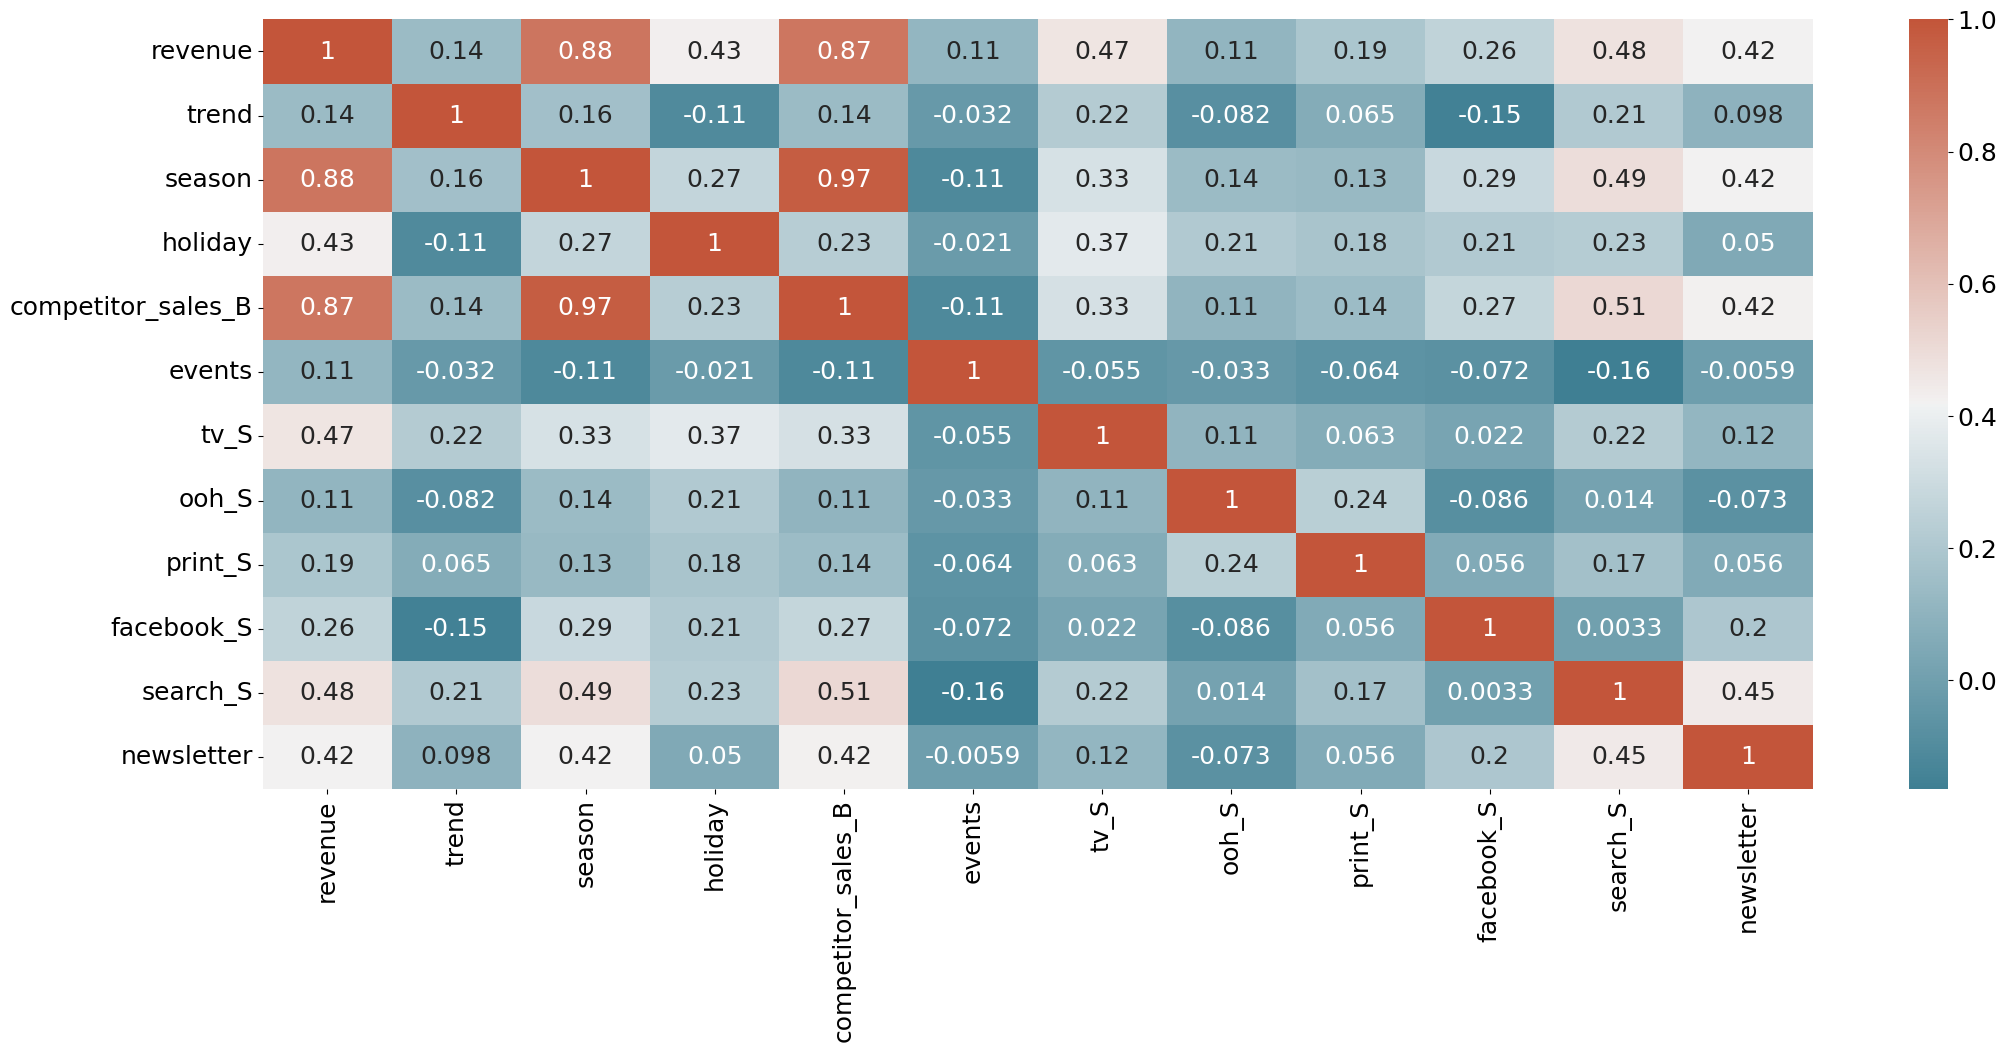

In [ ]:
corr = data.loc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX - 1, [target] + features].corr()


fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted


# Apply a geometric decay transformation to this time series data.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
import numpy as np

# Write a custom transformer for applying geometric decay transformation (Adstock) to the time series data.
class AdstockGeometric(BaseEstimator, TransformerMixin):
    """
    Parameters:
    -----------
    alpha : float, optional, default: 0.5
        The decay factor controlling how fast the weights decrease exponentially.

    Methods:
    --------
    fit(X, y=None):
        Fit the adstock transformer to the input time series data.

    transform(X):
        Apply adstock geometric decay transformation to the input time series.

    """

    def __init__(self, alpha=0.5):
        self.alpha = alpha

    def fit(self, X, y=None):
        """
        Fit the adstock transformer to the input time series data.

        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Input time series data.
        y : None
            Ignored. Not used in the transformation.

        Returns:
        --------
        self : object
            Returns an instance of the fitted transformer.

        """
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.fitted_ = True  # Corrected attribute name
        return self

    def transform(self, X):
        """
        Apply adstock geometric decay transformation to the input time series.

        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Input time series data.

        Returns:
        --------
        x_decayed : np.ndarray
            Transformed time series with adstock effect applied.

        """
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]

        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha * x_decayed[xi - 1]

        return x_decayed

    def _check_n_features(self, X, reset=False):
        """
        Helper method to check the number of features in the input data.

        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Input time series data.
        reset : bool, optional, default: False
            Ignored. Not used in this implementation.

        """
        pass


# Define evaluation metrics
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

#https://github.com/facebookexperimental/Robyn
def rssd(effect_share, spend_share):
    """RSSD decomposition

    Decomposition distance (root-sum-square distance, a major innovation of Robyn)
    eliminates the majority of "bad models"
    (larger prediction error and/or unrealistic media effect like the smallest channel getting the most effect

    Args:
        effect_share ([type]): percentage of effect share
        spend_share ([type]): percentage of spend share

    Returns:
        [type]: [description]
    """
    return np.sqrt(np.sum((effect_share - spend_share) ** 2))


def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34

    Returns:
        [plotnine]: plotnine plot
    """

    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size,
                    legend_direction='vertical',
                    legend_title=element_blank(),
                    legend_key_size=20,
                    legend_entry_spacing_y=5)
    return plt


def calculate_spend_effect_share(df_shap_values: pd.DataFrame, media_channels, df_original: pd.DataFrame):
    """
    Args:
        df_shap_values: data frame of shap values
        media_channels: list of media channel names
        df_original: non transformed original data
    Returns:
        [pd.DataFrame]: data frame with spend effect shares
    """
    responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
    response_percentages = responses / responses.sum()
    response_percentages

    spends_percentages = pd.DataFrame(df_original[media_channels].sum(axis = 0) / df_original[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
    spends_percentages

    spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
    spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})

    return spend_effect_share


#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
def shap_feature_importance(shap_values, data, figsize = (20, 10)):

    feature_list = data.columns

    if isinstance(shap_values, pd.DataFrame) == False:
        shap_v = pd.DataFrame(shap_values)
        shap_v.columns = feature_list
    else:
        shap_v = shap_values


    df_v = data.copy().reset_index().drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=figsize,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

def model_refit(data,
                target,
                features,
                media_channels,
                organic_channels,
                model_params,
                adstock_params,
                start_index,
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    #apply adstock transformation
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha}")

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

    #build the final model on the data until the end analysis index
    x_input = data_refit.loc[0:end_index-1, features]
    y_true_all = data[target].values[0:end_index]

    #build random forest using the best parameters
    xgboost = XGBRegressor(random_state=0, **best_params)
    xgboost.fit(x_input, y_true_all)


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)}")
    prediction = xgboost.predict(x_input_interval_transformed)

    #transformed data set for the analysis interval
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    #shap explainer
    explainer = shap.TreeExplainer(xgboost)

    # get SHAP values for the data set for the analysis interval from explainer model
    shap_values_train = explainer.shap_values(x_input_interval_transformed)

    # create a dataframe of the shap values for the training set and the test set
    df_shap_values = pd.DataFrame(shap_values_train, columns=features)

    return {
            'df_shap_values': df_shap_values,
            'x_input_interval_nontransformed': x_input_interval_nontransformed,
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction,
            'y_true_interval': y_true_interval
           }

def plot_shap_vs_spend(df_shap_values, x_input_interval_nontransformed, x_input_interval_transformed, features, media_channels, figsize=(25, 10)):
    for channel in media_channels:

        #index = features.index(channel)

        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(x = x_input_interval_transformed[channel], y = df_shap_values[channel], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    lowess=True, ax=ax).set(title=f'{channel}: Spend vs Shapley')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'SHAP Value for {channel}')
        plt.legend()

In [ ]:
media_channels

['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']

In [ ]:
# Modeling with XgBoost
def optuna_trial(trial,
                 data:pd.DataFrame,
                 target,
                 features,
                 adstock_features,
                 adstock_features_params,
                 media_features,
                 tscv,
                 is_multiobjective = False):

    data_temp = data.copy()
    adstock_alphas = {}

    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_float(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha

        ############ adstock transformation ############
        x_feature = data[feature].values.reshape(-1, 1)

        # Create an instance of AdstockGeometric
        adstock_transformer = AdstockGeometric(alpha=adstock_alpha)

        # Fit the transformer on the training data
        adstock_transformer.fit(x_feature)

        # Transform the data using the fitted transformer
        temp_adstock = adstock_transformer.transform(x_feature)

        data_temp[feature] = temp_adstock #Replace existing media channels values with transformed adstock values
        ################################################

    #XgBoost parameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'max_depth': trial.suggest_int('max_depth', 4, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
    }
    scores = []

    rssds = []
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]

        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]

        #apply XgBoost

        xgboost = XGBRegressor(random_state=0, **params)
        xgboost.fit(x_train, y_train)
        prediction = xgboost.predict(x_test)

        # rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)


        mse = mean_squared_error(y_test, prediction)   # no 'squared' kw
        rmse = np.sqrt(mse)
        scores.append(rmse)

        if is_multiobjective:

            #set_trace()
            #calculate spend effect share -> rssd
            # create explainer model by passing trained model to shap
            explainer = shap.TreeExplainer(xgboost)

            # get Shap values
            shap_values_train = explainer.shap_values(x_train)

            df_shap_values = pd.DataFrame(shap_values_train, columns=features)

            spend_effect_share = calculate_spend_effect_share(df_shap_values = df_shap_values, media_channels = media_features, df_original = data.iloc[train_index])

            decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
            rssds.append(decomp_rssd)

    trial.set_user_attr("scores", scores)

    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)

    if is_multiobjective == False:
        return np.mean(scores)


    trial.set_user_attr("rssds", rssds)

    #multiobjective
    return np.mean(scores), np.mean(rssds)

In [ ]:
def optuna_optimize(trials,
                    data: pd.DataFrame,
                    target,
                    features,
                    adstock_features,
                    adstock_features_params,
                    media_features,
                    tscv,
                    is_multiobjective,
                    seed = 42):
    print(f"data size: {len(data)}")
    print(f"media features: {media_features}")
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")
    print(f"is_multiobjective: {is_multiobjective}")
    opt.logging.set_verbosity(opt.logging.WARNING)

    if is_multiobjective == False:
        study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed)) #Tree-structured Parzen Estimator (TPESampler)
    else:
        study_mmm = opt.create_study(directions=["minimize", "minimize"], sampler=opt.samplers.NSGAIISampler(seed=seed)) # NSGA-II (Non-dominated Sorting Genetic Algorithm II).

    #It fixes certain parameters (those passed to optuna_trial that don't change during optimization).
    optimization_function = partial(optuna_trial,
                                    data = data,
                                    target = target,
                                    features = features,
                                    adstock_features = adstock_features,
                                    adstock_features_params = adstock_features_params,
                                    media_features = media_features,
                                    tscv = tscv,
                                    is_multiobjective = is_multiobjective)

    #The optimization function (optuna_trial) is executed iteratively with different sets of hyperparameters, and the study seeks to minimize the objective function.
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)

    # returns the Optuna study (study_mmm) after optimization.
    return study_mmm

In [ ]:
features

['trend',
 'season',
 'holiday',
 'competitor_sales_B',
 'events',
 'tv_S',
 'ooh_S',
 'print_S',
 'facebook_S',
 'search_S',
 'newsletter']

In [ ]:
media_channels + organic_channels

['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.0, 0.4)
adstock_features_params["search_S_adstock"] = (0.0, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

# OPTUNA_TRIALS = 2000
OPTUNA_TRIALS = 2
experiment = optuna_optimize(trials = OPTUNA_TRIALS,
                             data = data,
                             target = target,
                             features = features,
                             adstock_features = media_channels + organic_channels,
                             adstock_features_params = adstock_features_params,
                             media_features=media_channels,
                             tscv = tscv,
                             is_multiobjective=False)

data size: 208
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
is_multiobjective: False


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
experiment


In [ ]:
experiment.best_trial.user_attrs["scores"]

[np.float64(312979.8129006406),
 np.float64(441930.318806878),
 np.float64(266350.16508033295)]

In [ ]:
experiment.best_trial.user_attrs["params"]


{'n_estimators': 10,
 'min_child_weight': 9,
 'subsample': 0.8005575058716043,
 'colsample_bytree': 0.8540362888980227,
 'max_depth': 4,
 'learning_rate': 0.09702107536403744,
 'reg_alpha': 0.8324426408004217,
 'reg_lambda': 0.21233911067827616,
 'gamma': 0.18182496720710062}

In [ ]:
experiment.best_trial.user_attrs["adstock_alphas"]


{'tv_S': 0.48727005942368123,
 'ooh_S': 0.38521429192297485,
 'print_S': 0.31959818254342154,
 'facebook_S': 0.23946339367881464,
 'search_S': 0.04680559213273095,
 'newsletter': 0.1467983561008608}

In [ ]:
experiment.best_params


{'adstock_alpha_tv_S': 0.48727005942368123,
 'adstock_alpha_ooh_S': 0.38521429192297485,
 'adstock_alpha_print_S': 0.31959818254342154,
 'adstock_alpha_facebook_S': 0.23946339367881464,
 'adstock_alpha_search_S': 0.04680559213273095,
 'adstock_alpha_newsletter': 0.1467983561008608,
 'n_estimators': 10,
 'min_child_weight': 9,
 'subsample': 0.8005575058716043,
 'colsample_bytree': 0.8540362888980227,
 'max_depth': 4,
 'learning_rate': 0.09702107536403744,
 'reg_alpha': 0.8324426408004217,
 'reg_lambda': 0.21233911067827616,
 'gamma': 0.18182496720710062}

In [ ]:
experiment.best_trial


FrozenTrial(number=0, state=1, values=[340420.09892928385], datetime_start=datetime.datetime(2025, 8, 17, 20, 1, 59, 683988), datetime_complete=datetime.datetime(2025, 8, 17, 20, 1, 59, 730475), params={'adstock_alpha_tv_S': 0.48727005942368123, 'adstock_alpha_ooh_S': 0.38521429192297485, 'adstock_alpha_print_S': 0.31959818254342154, 'adstock_alpha_facebook_S': 0.23946339367881464, 'adstock_alpha_search_S': 0.04680559213273095, 'adstock_alpha_newsletter': 0.1467983561008608, 'n_estimators': 10, 'min_child_weight': 9, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'max_depth': 4, 'learning_rate': 0.09702107536403744, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 0.21233911067827616, 'gamma': 0.18182496720710062}, user_attrs={'scores': [np.float64(312979.8129006406), np.float64(441930.318806878), np.float64(266350.16508033295)], 'params': {'n_estimators': 10, 'min_child_weight': 9, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'max_de

In [ ]:
np.mean(experiment.best_trial.user_attrs["scores"])


np.float64(340420.09892928385)

In [ ]:
experiment.best_trial.user_attrs["params"]


{'n_estimators': 10,
 'min_child_weight': 9,
 'subsample': 0.8005575058716043,
 'colsample_bytree': 0.8540362888980227,
 'max_depth': 4,
 'learning_rate': 0.09702107536403744,
 'reg_alpha': 0.8324426408004217,
 'reg_lambda': 0.21233911067827616,
 'gamma': 0.18182496720710062}

In [ ]:
experiment.best_trial.user_attrs["adstock_alphas"]


{'tv_S': 0.48727005942368123,
 'ooh_S': 0.38521429192297485,
 'print_S': 0.31959818254342154,
 'facebook_S': 0.23946339367881464,
 'search_S': 0.04680559213273095,
 'newsletter': 0.1467983561008608}

In [ ]:
# Model Refit
best_params = experiment.best_trial.user_attrs["params"]
adstock_params = experiment.best_trial.user_attrs["adstock_alphas"]
result = model_refit(data = data,
                     target = target,
                     features = features,
                     media_channels = media_channels,
                     organic_channels = organic_channels,
                     model_params = best_params,
                     adstock_params = adstock_params,
                     start_index = START_ANALYSIS_INDEX,
                     end_index = END_ANALYSIS_INDEX)

applying geometric adstock transformation on tv_S with alpha 0.48727005942368123
applying geometric adstock transformation on ooh_S with alpha 0.38521429192297485
applying geometric adstock transformation on print_S with alpha 0.31959818254342154
applying geometric adstock transformation on facebook_S with alpha 0.23946339367881464
applying geometric adstock transformation on search_S with alpha 0.04680559213273095
applying geometric adstock transformation on newsletter with alpha 0.1467983561008608
predicting 92


In [ ]:
type(result)

dict

In [ ]:
result.keys()

dict_keys(['df_shap_values', 'x_input_interval_nontransformed', 'x_input_interval_transformed', 'prediction_interval', 'y_true_interval'])

In [ ]:

!mkdir results
for key, value in result.items():
  if type(value) == pd.DataFrame:

    result[key].to_csv(f"./results/{key}.csv")

In [ ]:
pd.DataFrame({'prediction_interval': result['prediction_interval'] }).to_csv(f"./results/prediction_interval.csv")

In [ ]:
pd.DataFrame({'y_true_interval': result['y_true_interval'] }).to_csv(f"./results/y_true_interval.csv")

RMSE: 390543.7951786864
MAPE: 0.19484209305975103
NRMSE: 0.12674856192333944
R2: 0.7291684672365559


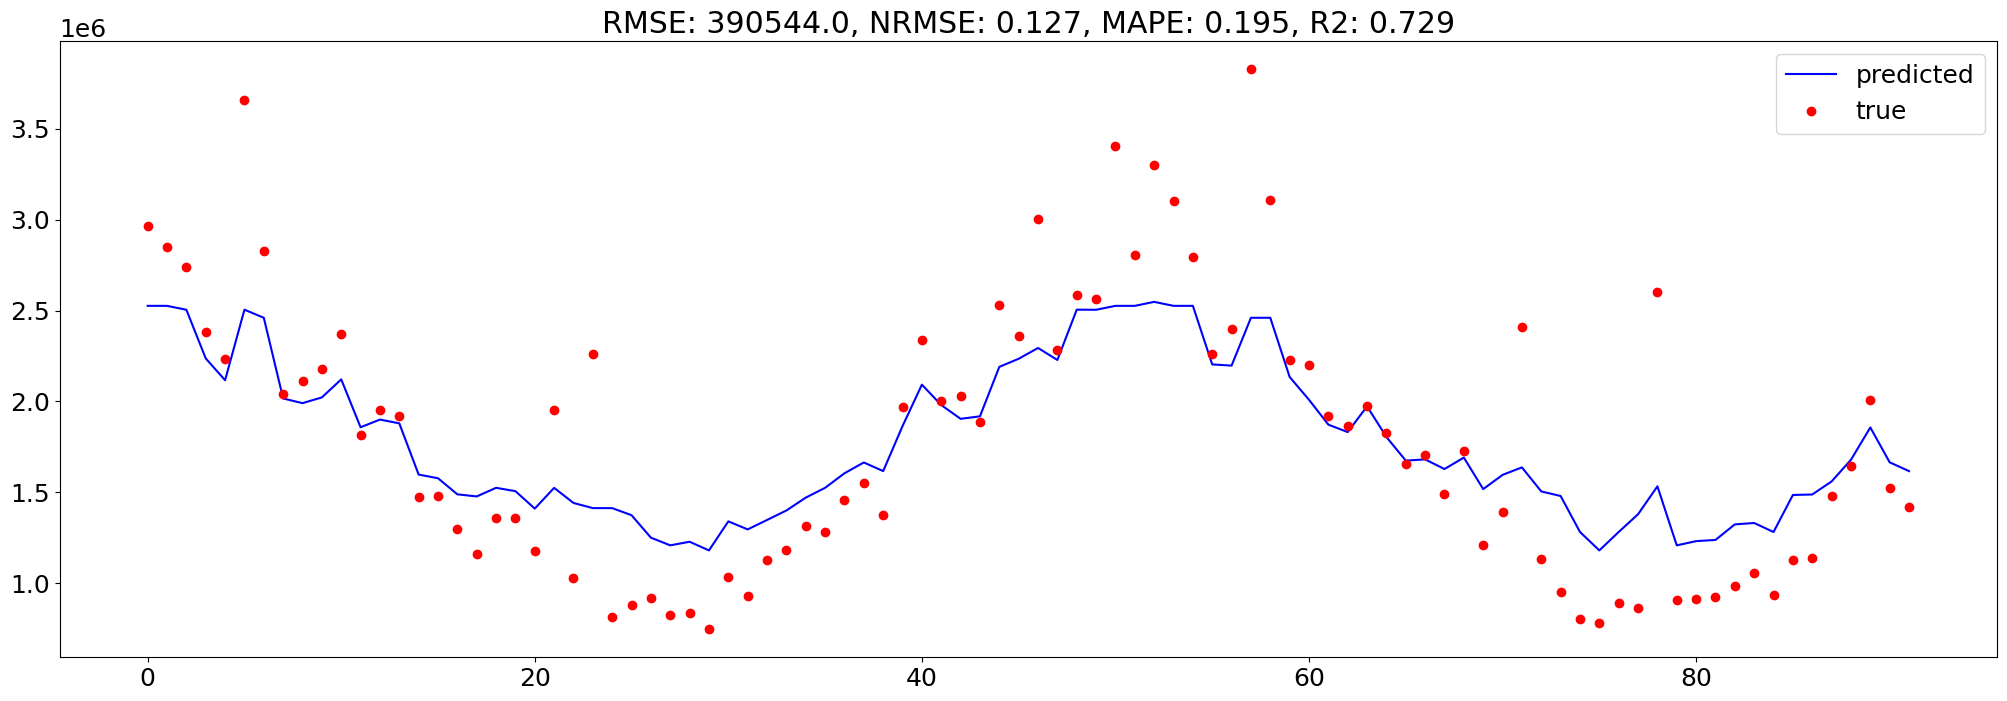

In [ ]:
# Metrics
# rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)

mse = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])
rmse_metric = np.sqrt(mse)


mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])
nrmse_metric = nrmse(result["y_true_interval"], result["prediction_interval"])
r2_metric = r2_score(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])

print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')
print(f'NRMSE: {nrmse_metric}')
print(f'R2: {r2_metric}')


fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(result["prediction_interval"], color = "blue", label = "predicted")
_ = ax.plot(result["y_true_interval"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, NRMSE: {np.round(nrmse_metric, 3)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
_ = ax.legend()

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning:

invalid value encountered in divide



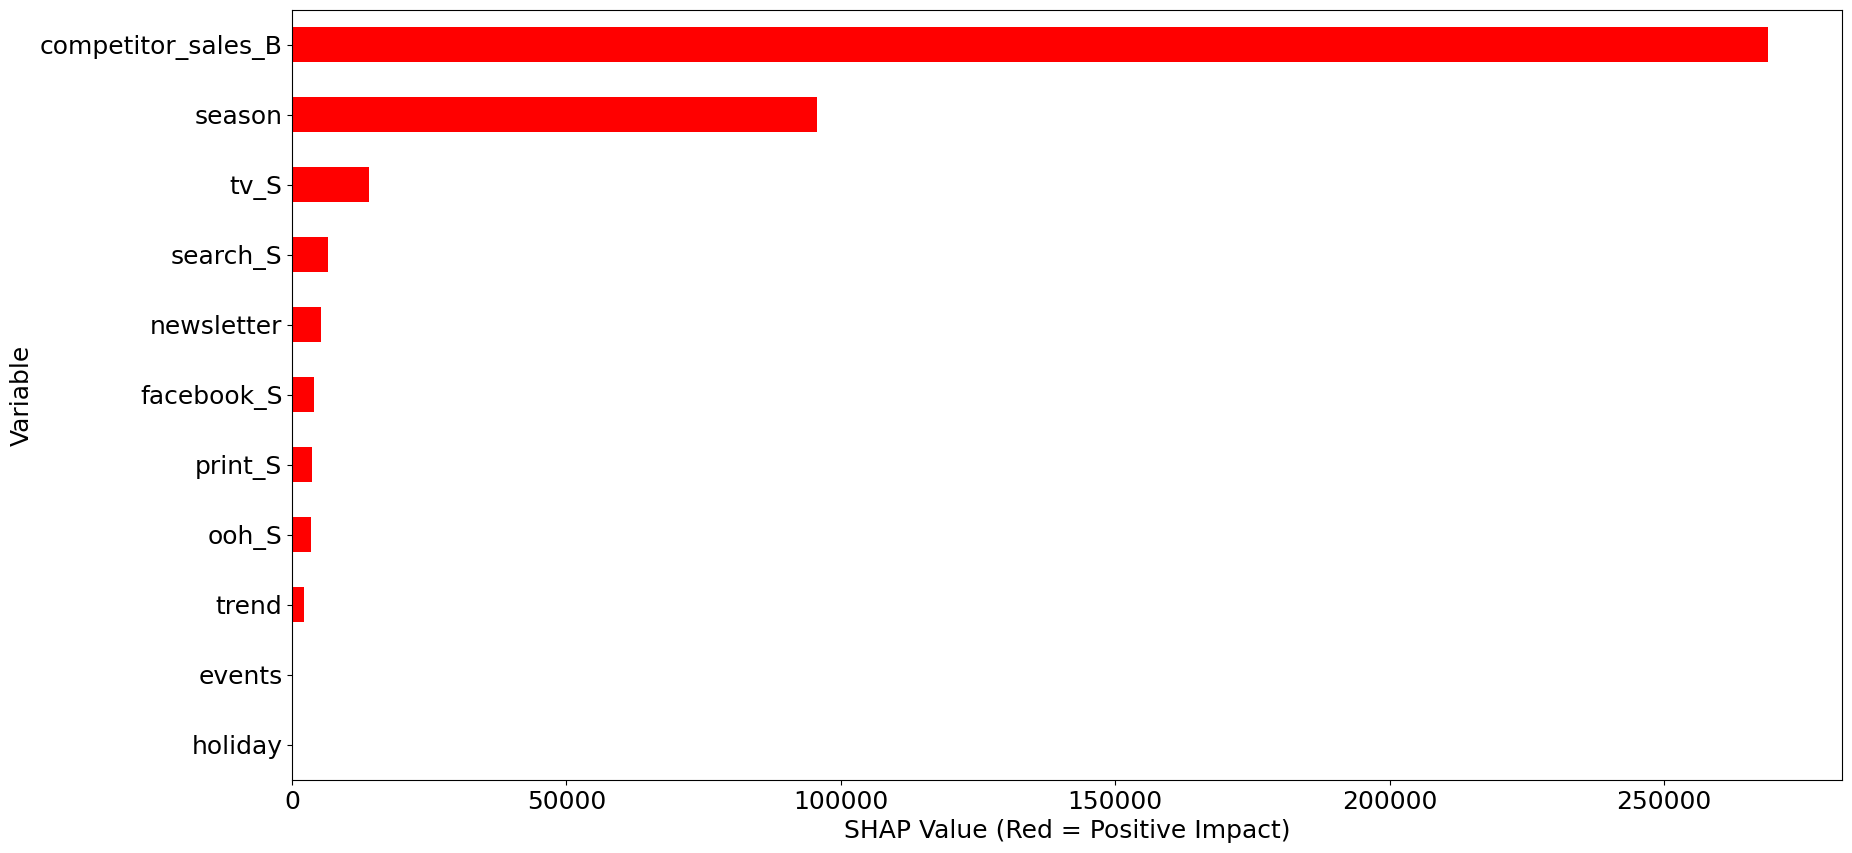

In [ ]:
# Feature Importance
shap_feature_importance(result["df_shap_values"], result["x_input_interval_transformed"])

In [ ]:
spend_effect_share = calculate_spend_effect_share(df_shap_values = result["df_shap_values"], media_channels = media_channels, df_original = result["x_input_interval_nontransformed"])

decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
print(f"DECOMP.RSSD: {decomp_rssd}")
print(plot_spend_vs_effect_share(spend_effect_share, figure_size = (15, 7)))

DECOMP.RSSD: 0.2680417474421433
<ggplot: (1500 x 700)>


/tmp/ipython-input-1375029343.py:141: FutureWarning:


Themeable 'legend_entry_spacing_y' has been renamed to 'legend_key_spacing_y'.
'legend_entry_spacing_y' is now deprecated and will be removed in a future release.



In [ ]:
!pip install -q statsmodels
import statsmodels.api as sm


In [ ]:
# plot_shap_vs_spend(result["df_shap_values"], result["x_input_interval_nontransformed"], result["x_input_interval_transformed"], features, media_channels)


In [ ]:
# Multiobjective
tscv = TimeSeriesSplit(n_splits=3, test_size = 10)

# OPTUNA_MULTIOBJECTIVE_TRIALS = 1000
OPTUNA_MULTIOBJECTIVE_TRIALS = 2

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.0, 0.4)
adstock_features_params["search_S_adstock"] = (0.0, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

experiment_multi = optuna_optimize(trials = OPTUNA_MULTIOBJECTIVE_TRIALS,
                                   data = data,
                                   target = target,
                                   features = features,
                                   adstock_features=media_channels + organic_channels,
                                   adstock_features_params = adstock_features_params,
                                   media_features=media_channels,
                                   tscv = tscv,
                                   is_multiobjective=True)


data size: 208
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
is_multiobjective: True


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fig = opt.visualization.plot_pareto_front(experiment_multi, target_names = ["RMSE", "RSSD"])
fig.show()

In [ ]:
#how many best models
len(experiment_multi.best_trials)

2

In [ ]:
import pickle
def final_model_refit(data,
                target,
                features,
                media_channels,
                organic_channels,
                model_params,
                adstock_params,
                start_index,
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    #apply adstock transformation
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha}")

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

    #build the final model on the data until the end analysis index
    x_input = data_refit.loc[0:end_index-1, features]
    y_true_all = data[target].values[0:end_index]

    #build random forest using the best parameters
    xgboost = XGBRegressor(random_state=0, **best_params)
    xgboost.fit(x_input, y_true_all)


    # Save the model to a file using pickle
    model_filename = "./final_xgboost_model.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(xgboost, model_file)

    print(f"Final model saved to {model_filename}")



In [ ]:
# Iterate through best models and rebuild
multi_results = []
for trial in experiment_multi.best_trials:
    multi_result = model_refit(data = data,
                     target = target,
                     features = features,
                     media_channels = media_channels,
                     organic_channels = organic_channels,
                     model_params = trial.user_attrs["params"],
                     adstock_params = trial.user_attrs["adstock_alphas"],
                     start_index = START_ANALYSIS_INDEX,
                     end_index = END_ANALYSIS_INDEX)

    print(f'RMSE: {np.sqrt(mean_squared_error(y_true = multi_result["y_true_interval"], y_pred = multi_result["prediction_interval"]))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true = multi_result["y_true_interval"], y_pred = multi_result["prediction_interval"])}')
    print(f'NRMSE: {nrmse(multi_result["y_true_interval"], multi_result["prediction_interval"])}')
    print(f'R2: {r2_score(y_true = multi_result["y_true_interval"], y_pred = multi_result["prediction_interval"])}')
    print("")

    spend_effect_share_multi = calculate_spend_effect_share(df_shap_values = multi_result["df_shap_values"], media_channels = media_channels, df_original = multi_result["x_input_interval_nontransformed"])
    decomp_rssd_multi = rssd(effect_share = spend_effect_share_multi.effect_share.values, spend_share = spend_effect_share_multi.spend_share.values)
    print(f"DECOMP.RSSD: {decomp_rssd_multi}")
    print(plot_spend_vs_effect_share(spend_effect_share_multi, figure_size = (15, 7)))

    multi_results.append(multi_result)


applying geometric adstock transformation on tv_S with alpha 0.48727005942368123
applying geometric adstock transformation on ooh_S with alpha 0.38521429192297485
applying geometric adstock transformation on print_S with alpha 0.31959818254342154
applying geometric adstock transformation on facebook_S with alpha 0.23946339367881464
applying geometric adstock transformation on search_S with alpha 0.04680559213273095
applying geometric adstock transformation on newsletter with alpha 0.1467983561008608
predicting 92
RMSE: 390543.7951786864
MAPE: 0.19484209305975103
NRMSE: 0.12674856192333944
R2: 0.7291684672365559

DECOMP.RSSD: 0.2680417474421433
<ggplot: (1500 x 700)>
applying geometric adstock transformation on tv_S with alpha 0.3917022549267169
applying geometric adstock transformation on ooh_S with alpha 0.19127267288786132
applying geometric adstock transformation on print_S with alpha 0.2574269294896714
applying geometric adstock transformation on facebook_S with alpha 0.17277800745

/tmp/ipython-input-1375029343.py:141: FutureWarning:


Themeable 'legend_entry_spacing_y' has been renamed to 'legend_key_spacing_y'.
'legend_entry_spacing_y' is now deprecated and will be removed in a future release.

/tmp/ipython-input-1375029343.py:141: FutureWarning:


Themeable 'legend_entry_spacing_y' has been renamed to 'legend_key_spacing_y'.
'legend_entry_spacing_y' is now deprecated and will be removed in a future release.



In [ ]:
final_model_refit(data = data,
                  target = target,
                  features = features,
                  media_channels = media_channels,
                  organic_channels = organic_channels,
                  model_params = experiment_multi.best_trials[0].user_attrs["params"],
                  adstock_params = experiment_multi.best_trials[0].user_attrs["adstock_alphas"],
                  start_index = START_ANALYSIS_INDEX,
                  end_index = END_ANALYSIS_INDEX)

applying geometric adstock transformation on tv_S with alpha 0.48727005942368123
applying geometric adstock transformation on ooh_S with alpha 0.38521429192297485
applying geometric adstock transformation on print_S with alpha 0.31959818254342154
applying geometric adstock transformation on facebook_S with alpha 0.23946339367881464
applying geometric adstock transformation on search_S with alpha 0.04680559213273095
applying geometric adstock transformation on newsletter with alpha 0.1467983561008608
Final model saved to ./final_xgboost_model.pkl


In [ ]:
data.iloc[END_ANALYSIS_INDEX:END_ANALYSIS_INDEX+4]

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,trend,season,holiday
144,2018-08-27,1673551.66667,0.00000,0,0.00000,43864423.45446,82233.52452,64400,5541654,135254.19565,0.00000,48020.00000,3205873.10306,44306.07626,0.00000
145,2018-09-03,2061091.66667,87460.60000,127900,5793.33333,0.00000,93587.08560,73000,6397383,0.00000,0.00000,70855.00000,3205348.77690,264842.12084,8659.26642
146,2018-09-10,2144110.00000,0.00000,0,4020.00000,0.00000,90903.05147,78800,7137648,0.00000,0.00000,46225.00000,3204824.41140,397816.90157,0.00000
147,2018-09-17,2058653.33333,0.00000,86476,72638.00000,41405945.34218,94015.68888,70200,6541298,102086.83325,0.00000,74995.00000,3204300.04590,437511.48526,0.00000


Test RMSE: 69821.32960192967
Test MAE: 67600.3020833325
Test R2 Score: 0.8539639086989071


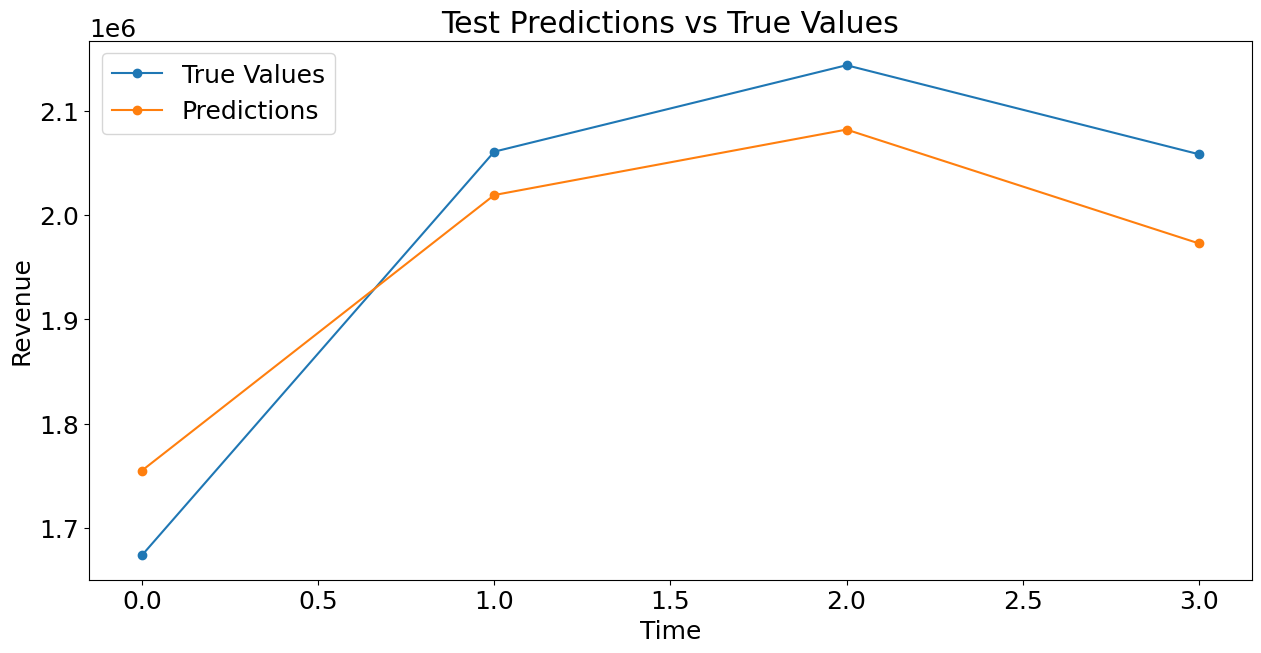

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Specify the start and end indices for the test
START_TEST_INDEX = END_ANALYSIS_INDEX
END_TEST_INDEX = END_ANALYSIS_INDEX+4
test_data = data
# # Specify your target, features, media channels, and organic channels
# target = "revenue"
# media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
# organic_channels = ["newsletter"]
# features = ["trend", "season", "holiday", "competitor_sales_B", "events"] + media_channels + organic_channels

# Load the final XGBoost model
model_filename = "./final_xgboost_model.pkl"  # Replace with the actual filename
with open(model_filename, 'rb') as model_file:
    final_xgboost_model = pickle.load(model_file)

# Apply adstock transformation to the test data
adstock_params = {'tv_S': 0.5, 'ooh_S': 0.3, 'print_S': 0.2, 'facebook_S': 0.1, 'search_S': 0.0, 'newsletter': 0.2}
for feature in media_channels + organic_channels:
    adstock_alpha = adstock_params[feature]
    x_feature = test_data[feature].values.reshape(-1, 1)
    temp_adstock = AdstockGeometric(alpha=adstock_alpha).fit_transform(x_feature)
    test_data[feature] = temp_adstock

# Extract features and target for the test dataset
x_test = test_data.loc[START_TEST_INDEX:END_TEST_INDEX-1, features]
y_true_test = test_data[target].values[START_TEST_INDEX:END_TEST_INDEX]

# Make predictions using the final model
predictions_test = final_xgboost_model.predict(x_test)

# Evaluate the performance metrics
rmse_test = np.sqrt(mean_squared_error(y_true=y_true_test, y_pred=predictions_test))
mae_test = mean_absolute_error(y_true=y_true_test, y_pred=predictions_test)
r2_test = r2_score(y_true=y_true_test, y_pred=predictions_test)

print(f'Test RMSE: {rmse_test}')
print(f'Test MAE: {mae_test}')
print(f'Test R2 Score: {r2_test}')

# Optionally, you can visualize the predictions and true values
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(y_true_test, label='True Values', marker='o')
plt.plot(predictions_test, label='Predictions', marker='o')
plt.title('Test Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [ ]:

!mkdir multi_result
for key, value in multi_result.items():
  if type(value) == pd.DataFrame:

    result[key].to_csv(f"./multi_result/{key}.csv")

pd.DataFrame({'prediction_interval': multi_result['prediction_interval'] }).to_csv(f"./multi_result/prediction_interval.csv")

pd.DataFrame({'y_true_interval': multi_result['y_true_interval'] }).to_csv(f"./multi_result/y_true_interval.csv")

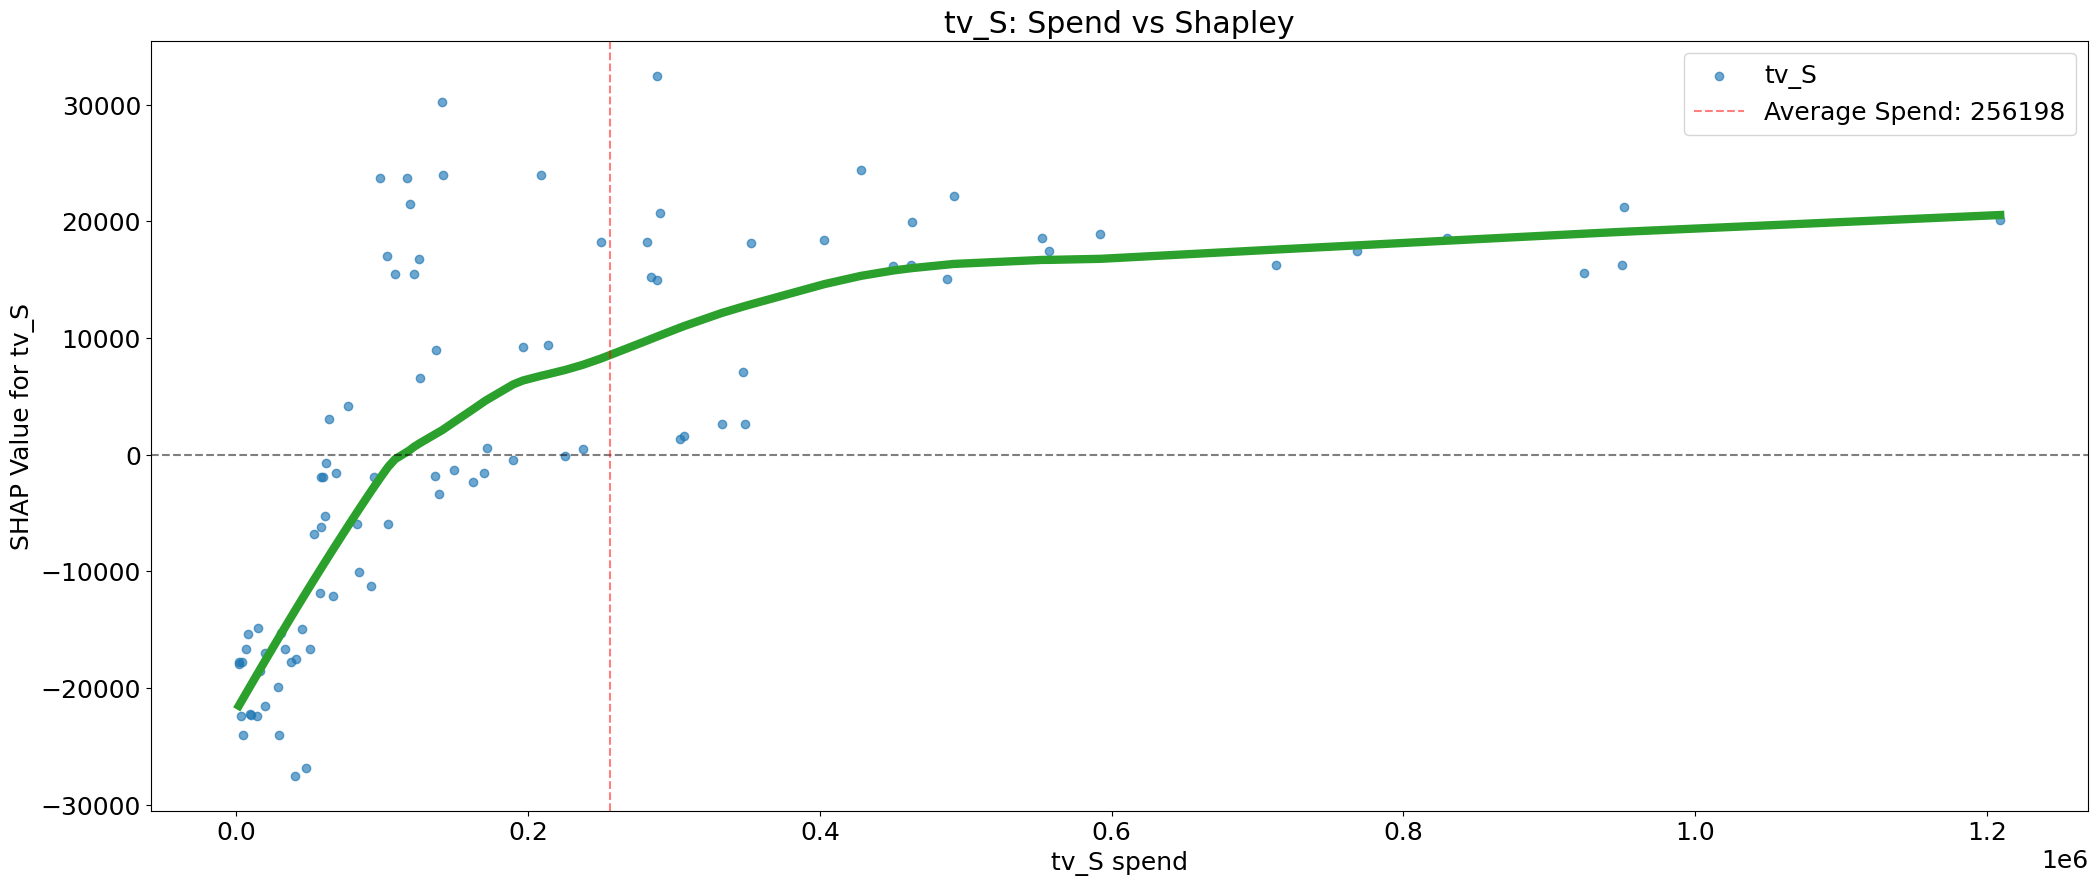

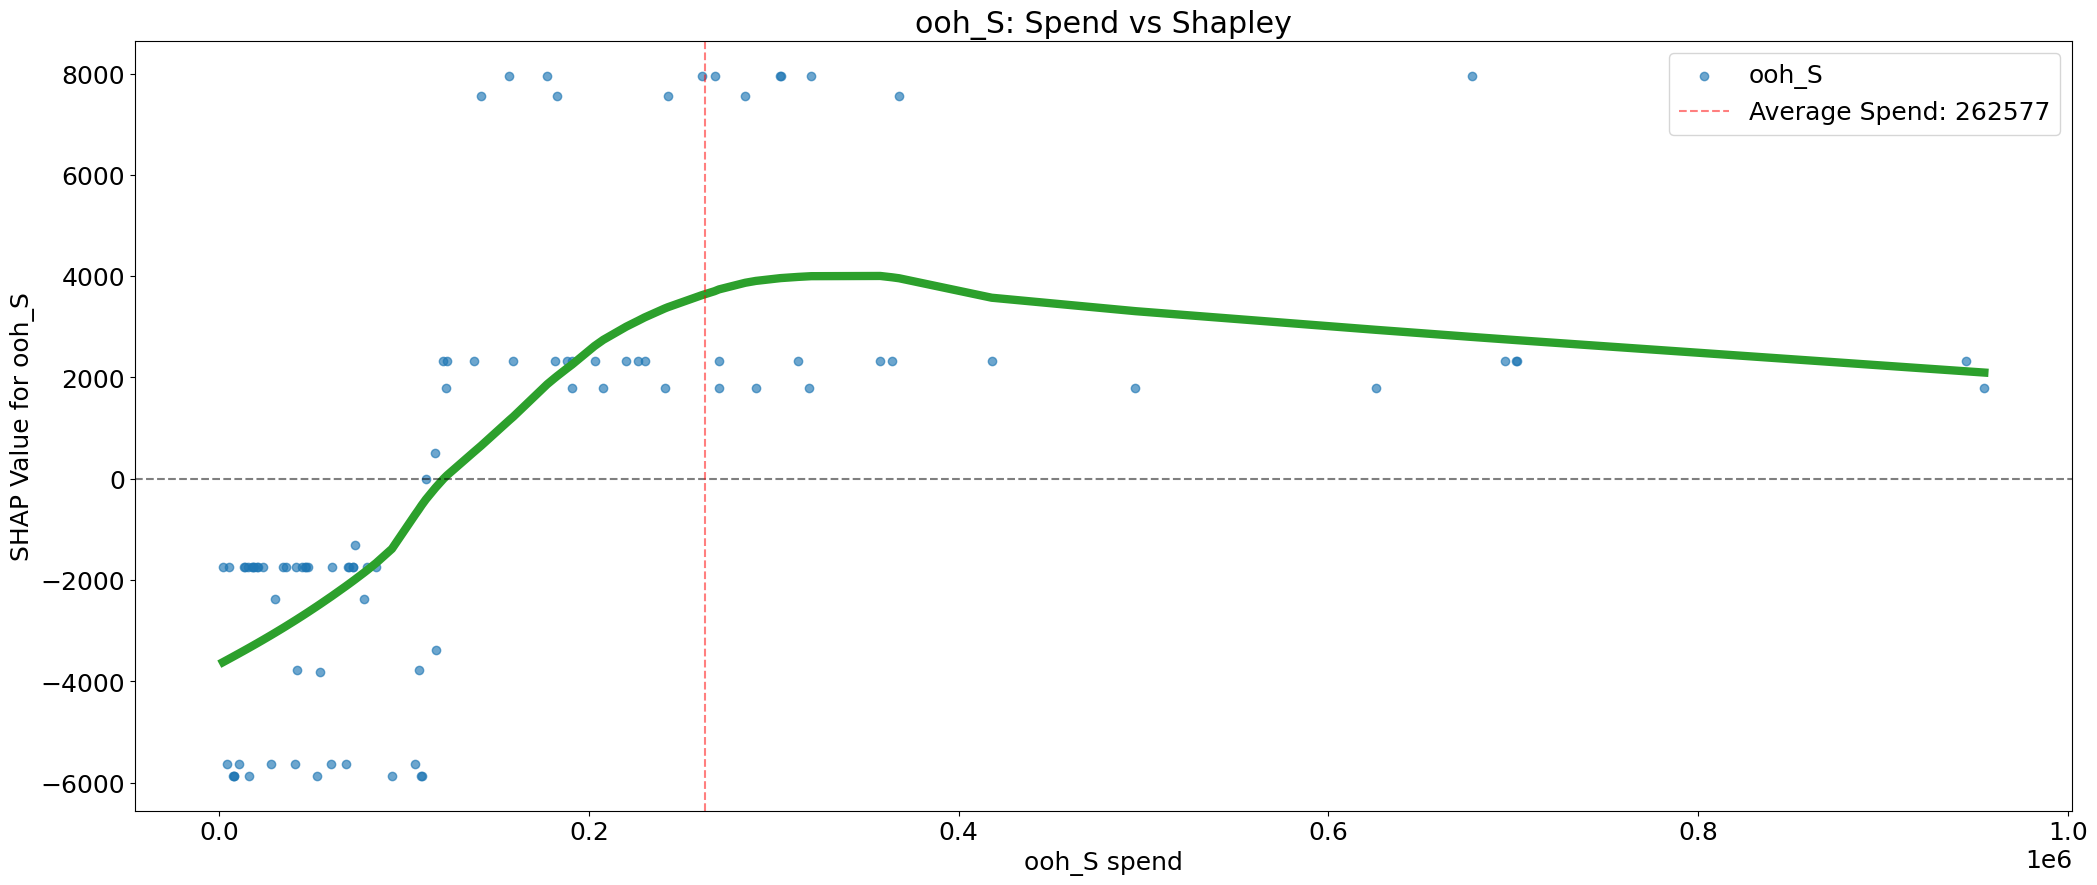

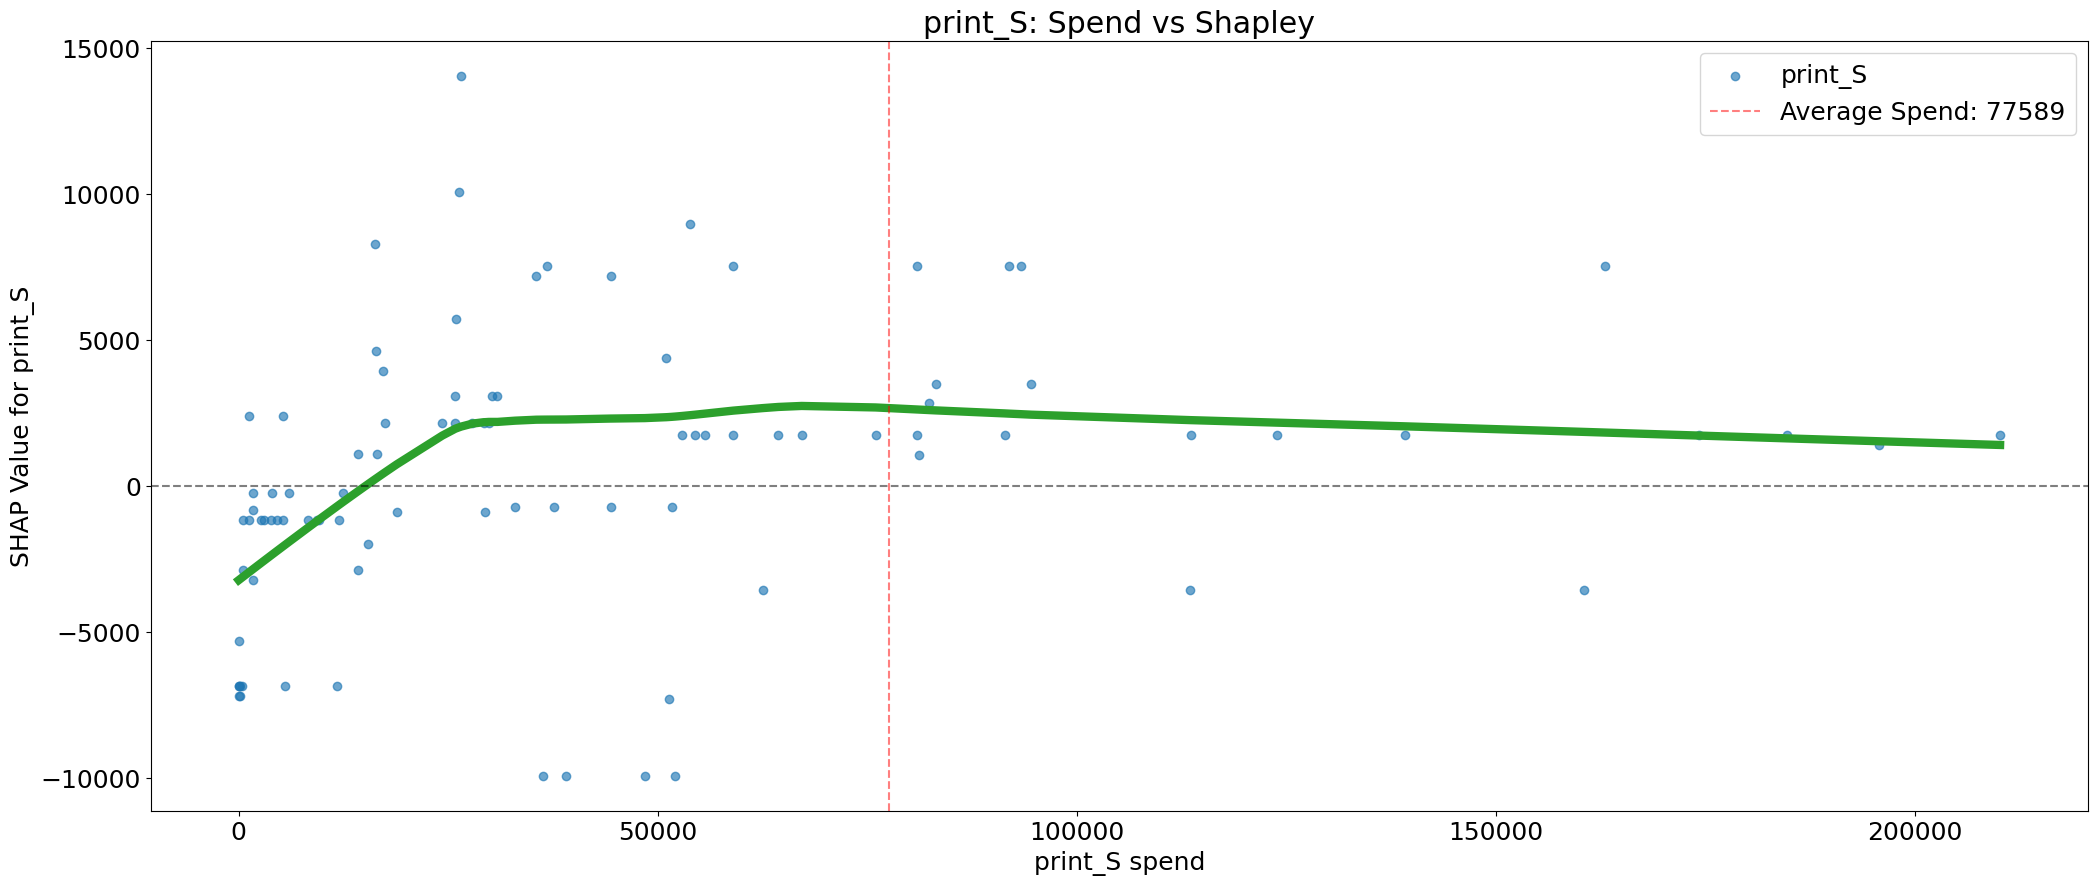

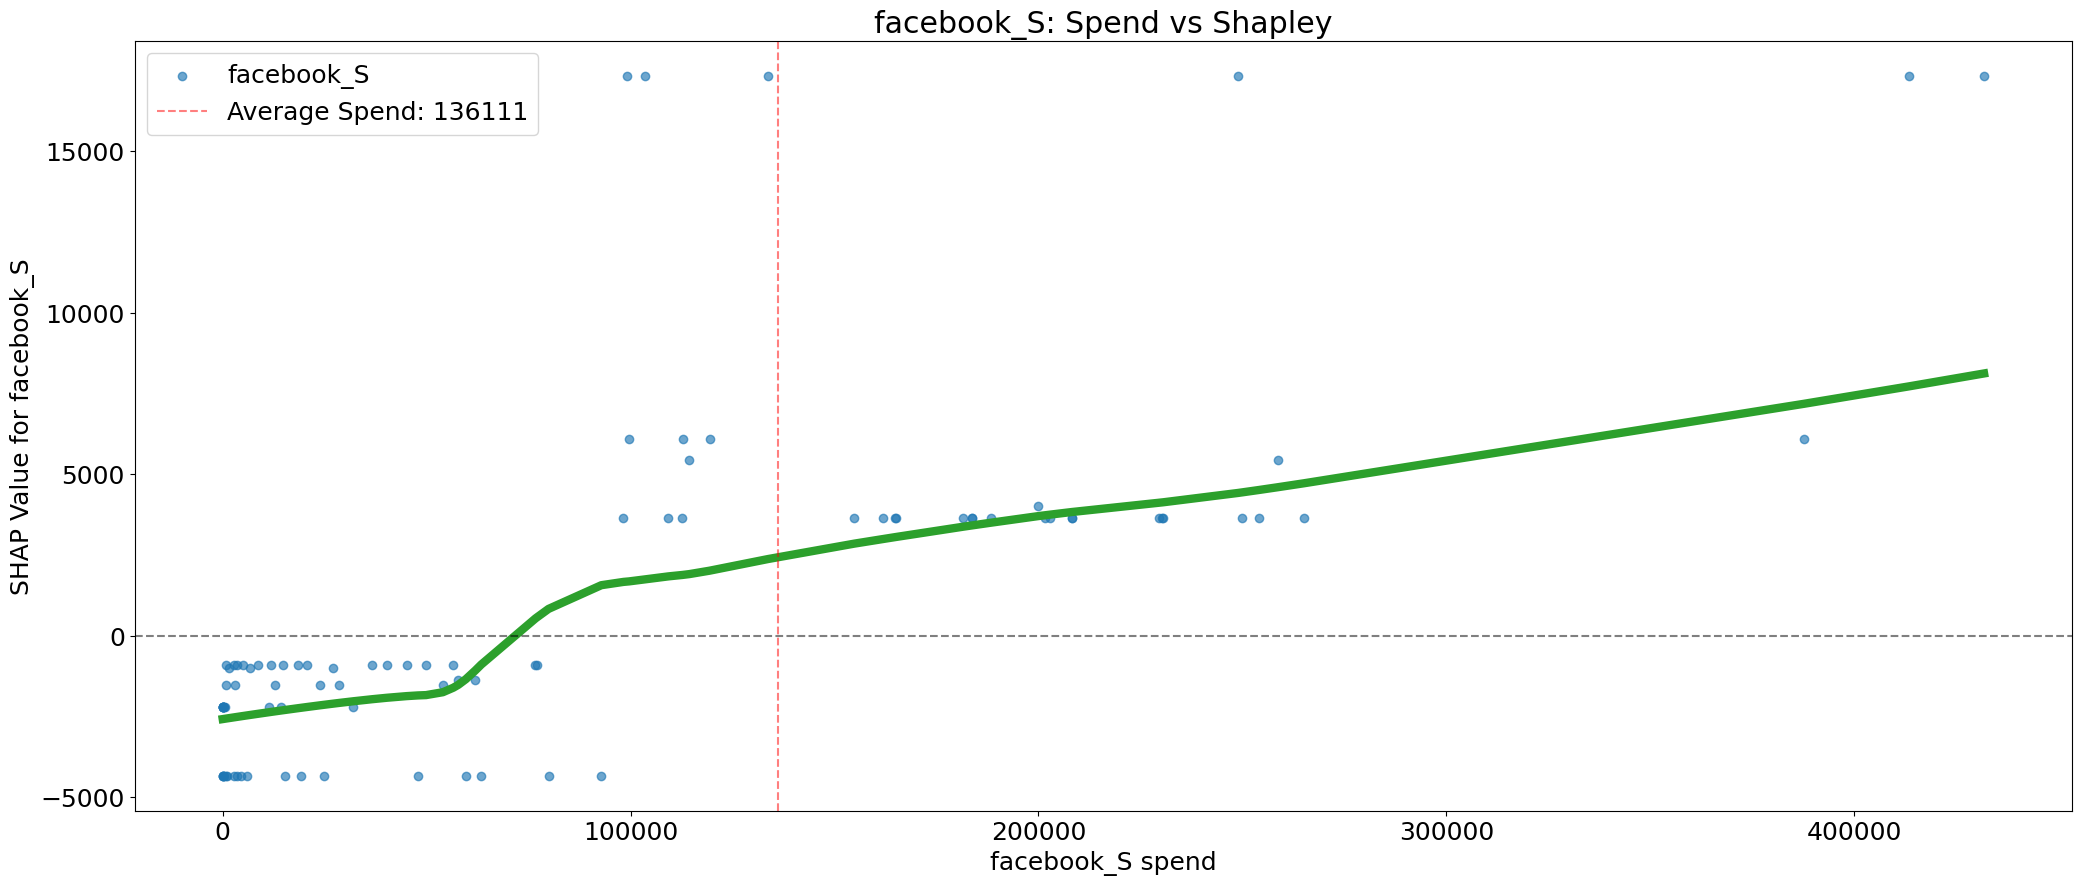

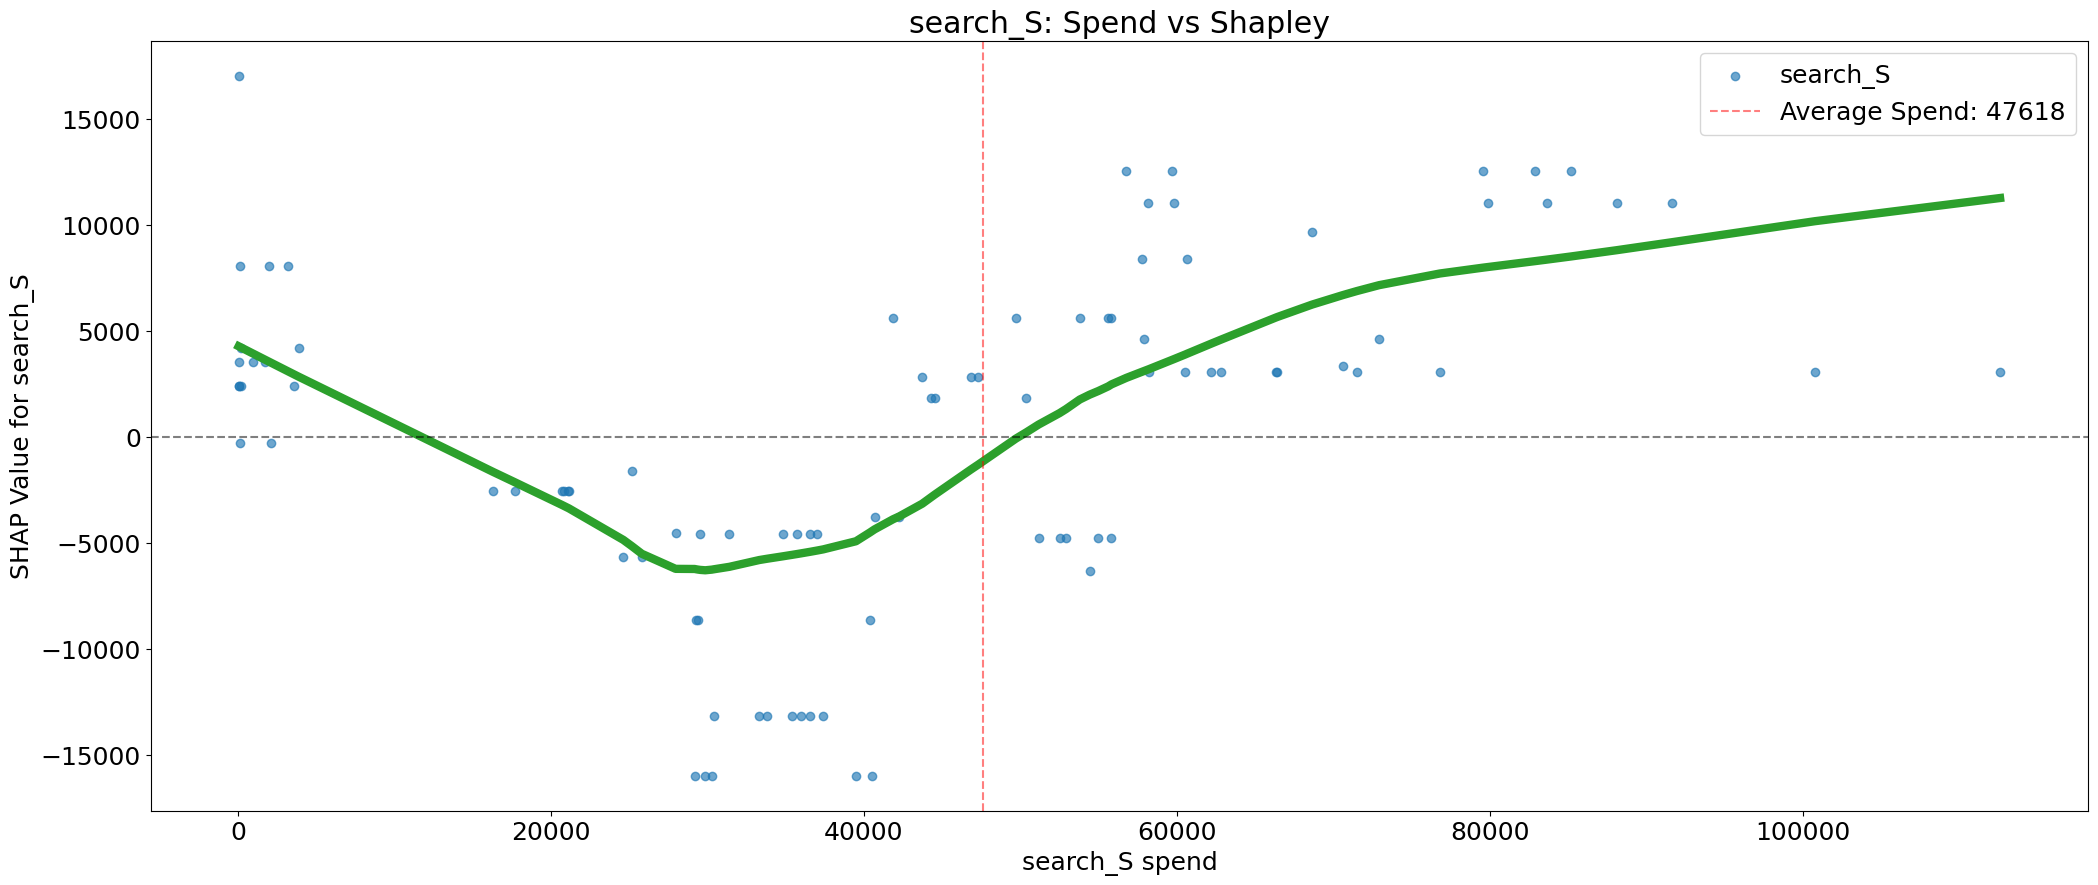

In [ ]:
#just take a single best model from pareto front
plot_shap_vs_spend(multi_results[0]["df_shap_values"], multi_results[0]["x_input_interval_nontransformed"], multi_results[0]["x_input_interval_transformed"], features, media_channels)

In [ ]:
#  model=final_xgboost_model,
#     base_df_window=window_df,
#     feature_cols=features,
#     media_cols=media_channels,
#     organic_cols=organic_channels,
#     adstock_params=adstock_params_used

In [ ]:
# base_df_window=window_df
# window_df.columns

In [ ]:
# feature_cols=features
# media_cols=media_channels
# organic_cols=organic_channels
# adstock_params=adstock_params_used
# feature_cols, media_cols, organic_cols, adstock_params

In [ ]:
# --- imports needed for new tasks ---
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- pick adstock params consistent with your final model ---
# If you saved them elsewhere, replace with that source
adstock_params_used = experiment_multi.best_trials[0].user_attrs["adstock_alphas"]

# ---------- NEW: helper to apply adstock like training ----------
def apply_adstock_to_df(df, channels, adstock_params):
    df2 = df.copy()
    for c in channels:
        x = df2[c].values.reshape(-1, 1)
        df2[c] = AdstockGeometric(alpha=adstock_params[c]).fit_transform(x)
    return df2

# ---------- NEW: ROAS / ROI via counterfactual contributions ----------
def compute_contributions_roas(model, base_df_window, feature_cols, media_cols, organic_cols, adstock_params):
    # prepare adstock-transformed features for window (same as training)
    tdf = apply_adstock_to_df(base_df_window, media_cols + organic_cols, adstock_params)
    X_full = tdf[feature_cols]
    y_full = model.predict(X_full).sum()

    spend = base_df_window[media_cols].sum()  # total spend per channel in window
    contrib = {}

    for c in media_cols:
        X_zero = X_full.copy()
        X_zero[c] = 0.0
        y_zero = model.predict(X_zero).sum()
        contrib[c] = y_full - y_zero

    contrib_s = pd.Series(contrib, name="contribution")
    spend_s = spend.rename("spend")
    df = pd.concat([spend_s, contrib_s], axis=1)
    df["roas"] = df["contribution"] / df["spend"].replace(0, np.nan)
    df["roi"] = df["roas"] - 1.0
    return df

# ---------- NEW: marginal ROAS around current spend path ----------
def compute_mroas(model, base_df_window, feature_cols, media_cols, organic_cols, adstock_params, eps=0.01):
    mroas = {}
    base_spend = base_df_window[media_cols].sum()

    for c in media_cols:
        up = base_df_window.copy(); up[c] = up[c] * (1.0 + eps)
        dn = base_df_window.copy(); dn[c] = dn[c] * (1.0 - eps)

        up_t = apply_adstock_to_df(up, media_cols + organic_cols, adstock_params)
        dn_t = apply_adstock_to_df(dn, media_cols + organic_cols, adstock_params)

        rev_up = model.predict(up_t[feature_cols]).sum()
        rev_dn = model.predict(dn_t[feature_cols]).sum()

        denom = ( (up[c].sum() - dn[c].sum()) )
        mroas[c] = (rev_up - rev_dn) / denom if denom != 0 else np.nan

    return pd.Series(mroas, name="mroas")

# ---------- NEW: budget optimizer (profit) ----------
# Drop-in replacement: same function name, same outputs; only adds total_budget param.
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def optimize_budget_profit(model, base_df_window, feature_cols, media_cols, organic_cols, adstock_params,
                           lb_mult=0.5, ub_mult=2.0, total_budget=None):
    current_spend = base_df_window[media_cols].sum()
    S0 = np.ones(len(media_cols))
    lbs = np.array([lb_mult]*len(media_cols))
    ubs = np.array([ub_mult]*len(media_cols))

    def eval_revenue_and_spend(scales):
        df = base_df_window.copy()
        for i, c in enumerate(media_cols):
            df[c] = df[c] * scales[i]
        dt = apply_adstock_to_df(df, media_cols + organic_cols, adstock_params)
        rev = model.predict(dt[feature_cols]).sum()
        tot_spend = df[media_cols].sum().sum()
        return rev, tot_spend

    # === key line changed: allow a custom fixed budget ===
    target_total = float(current_spend.sum() if total_budget is None else total_budget)

    cons = [{
        "type": "eq",
        "fun": lambda s: sum(base_df_window[c].sum()*s[i] for i,c in enumerate(media_cols)) - target_total
    }]
    bnds = list(zip(lbs, ubs))

    def objective(s):
        rev, tot_spend = eval_revenue_and_spend(s)
        return -(rev - tot_spend)  # same objective; under fixed total, this equals maximizing revenue

    res = minimize(objective, x0=S0, bounds=bnds, constraints=cons, method="SLSQP")
    scales_opt = res.x
    rev_opt, spend_opt = eval_revenue_and_spend(scales_opt)

    out = pd.DataFrame({
        "channel": media_cols,
        "scale": scales_opt,
        "current_spend": current_spend.values,
        "new_spend": current_spend.values * scales_opt
    })
    out["delta_spend"] = out["new_spend"] - out["current_spend"]
    return out, {"total_spend": spend_opt, "total_revenue": rev_opt, "profit": rev_opt - spend_opt, "success": res.success}

# ---------- NEW: budget optimizer to hit a revenue target with min spend ----------
def optimize_budget_to_target(model, base_df_window, feature_cols, media_cols, organic_cols, adstock_params,
                              revenue_target, lb_mult=0.0, ub_mult=3.0):
    current_spend = base_df_window[media_cols].sum()
    S0 = np.ones(len(media_cols))
    lbs = np.array([lb_mult]*len(media_cols))
    ubs = np.array([ub_mult]*len(media_cols))

    def eval_revenue_and_spend(scales):
        df = base_df_window.copy()
        for i, c in enumerate(media_cols):
            df[c] = df[c] * scales[i]
        dt = apply_adstock_to_df(df, media_cols + organic_cols, adstock_params)
        rev = model.predict(dt[feature_cols]).sum()
        tot_spend = df[media_cols].sum().sum()
        return rev, tot_spend

    # constraint: revenue >= target
    cons = [{"type":"ineq", "fun": lambda s: eval_revenue_and_spend(s)[0] - revenue_target}]
    bnds = list(zip(lbs, ubs))

    def objective(s):
        _, tot_spend = eval_revenue_and_spend(s)
        return tot_spend  # minimize spend

    res = minimize(objective, x0=S0, bounds=bnds, constraints=cons, method="SLSQP")
    scales_opt = res.x
    rev_opt, spend_opt = eval_revenue_and_spend(scales_opt)

    out = pd.DataFrame({
        "channel": media_cols,
        "scale": scales_opt,
        "current_spend": current_spend.values,
        "new_spend": current_spend.values * scales_opt
    })
    out["delta_spend"] = out["new_spend"] - out["current_spend"]
    return out, {"total_spend": spend_opt, "total_revenue": rev_opt, "profit": rev_opt - spend_opt, "success": res.success}

# ===================== Usage on your current run =====================

# Window to evaluate at "current spend"
window_df = data.loc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX-1].copy()

# 1) ROI / ROAS / mROAS
roas_df = compute_contributions_roas(
    model=final_xgboost_model,
    base_df_window=window_df,
    feature_cols=features,
    media_cols=media_channels,
    organic_cols=organic_channels,
    adstock_params=adstock_params_used
)
mroas_s = compute_mroas(
    model=final_xgboost_model,
    base_df_window=window_df,
    feature_cols=features,
    media_cols=media_channels,
    organic_cols=organic_channels,
    adstock_params=adstock_params_used,
    eps=0.01
)
roas_df = roas_df.join(mroas_s, how="left")
print("ROAS / ROI / mROAS at current spend (analysis window):")
print(roas_df.sort_values("roas", ascending=False))

# 2a) Reallocate to maximize profit at same total budget (bounds ±50%)
alloc_profit_df, profit_summary = optimize_budget_profit(
    model=final_xgboost_model,
    base_df_window=window_df,
    feature_cols=features,
    media_cols=media_channels,
    organic_cols=organic_channels,
    adstock_params=adstock_params_used,
    lb_mult=0.5, ub_mult=1.5
)
print("\nReallocation to maximize profit (same total spend):")
print(alloc_profit_df)
print("Summary:", profit_summary)

# 2b) Find minimal spend to reach a revenue target (example: +5% vs current)
# compute current revenue in window
tdf_curr = apply_adstock_to_df(window_df, media_channels + organic_channels, adstock_params_used)
rev_current = final_xgboost_model.predict(tdf_curr[features]).sum()
target = 1.05 * rev_current  # adjust as needed
alloc_target_df, target_summary = optimize_budget_to_target(
    model=final_xgboost_model,
    base_df_window=window_df,
    feature_cols=features,
    media_cols=media_channels,
    organic_cols=organic_channels,
    adstock_params=adstock_params_used,
    revenue_target=target,
    lb_mult=0.0, ub_mult=2.0
)
print(f"\nMinimal spend to reach revenue target ({target:.2f}):")
print(alloc_target_df)
print("Summary:", target_summary)


ROAS / ROI / mROAS at current spend (analysis window):
                    spend  contribution     roas      roi   mroas
tv_S       20626178.20632 3163328.00000  0.15336 -0.84664 0.08025
print_S     3495440.12565  291232.00000  0.08332 -0.91668 0.00000
ooh_S      14575033.00000  437632.00000  0.03003 -0.96997 0.00000
facebook_S  6673165.80882  173008.00000  0.02593 -0.97407 0.00000
search_S    3666600.00000 -397952.00000 -0.10853 -1.10853 0.77543

Reallocation to maximize profit (same total spend):
      channel   scale  current_spend      new_spend  delta_spend
0        tv_S 1.00000 20626178.20632 20626178.20632      0.00000
1       ooh_S 1.00000 14575033.00000 14575033.00000      0.00000
2     print_S 1.00000  3495440.12565  3495440.12565      0.00000
3  facebook_S 1.00000  6673165.80882  6673165.80882      0.00000
4    search_S 1.00000  3666600.00000  3666600.00000      0.00000
Summary: {'total_spend': np.float64(49036417.140790954), 'total_revenue': np.float32(165435580.0), 'profit

In [ ]:
zxdasda

In [ ]:
# =========================
# NEW FUNCTION 1:
# Diminishing returns (saturation) & optimal spend per channel
# Reuses: apply_adstock_to_df, AdstockGeometric, final_xgboost_model
# =========================
import numpy as np
import pandas as pd

# target = "revenue"

def find_saturation_and_optimal(model,
                                base_df_window,
                                feature_cols,
                                media_cols,
                                organic_cols,
                                adstock_params,
                                margin=1.0,
                                scale_grid=None):
    """
    Returns:
      curves_dict: {channel: DataFrame with columns:
         ['channel','scale','channel_spend','total_spend','total_revenue',
          'delta_spend','delta_revenue','mroas_fd','profit','delta_profit']}
      summary_df: one row per channel with:
         ['channel','base_spend','sat_spend','sat_scale','sat_mroas',
          'opt_spend','opt_scale','opt_delta_profit']
    """
    if scale_grid is None:
        scale_grid = np.linspace(0.0, 3.0, 31)

    # Baseline (others fixed)
    tdf_base = apply_adstock_to_df(base_df_window, media_cols + organic_cols, adstock_params)
    rev_base = model.predict(tdf_base[feature_cols]).sum()
    spend_base_total = base_df_window[media_cols].sum().sum()
    profit_base = rev_base - spend_base_total

    curves = {}
    summaries = []

    for channel in media_cols:
        spend_base_channel = base_df_window[channel].sum()
        rows = []

        for s in scale_grid:
            df = base_df_window.copy()
            df[channel] = df[channel] * s

            dt = apply_adstock_to_df(df, media_cols + organic_cols, adstock_params)
            rev = model.predict(dt[feature_cols]).sum()
            tot_spend = df[media_cols].sum().sum()
            ch_spend = df[channel].sum()

            rows.append({
                "channel": channel,
                "scale": float(s),
                "channel_spend": float(ch_spend),
                "total_spend": float(tot_spend),
                "total_revenue": float(rev),
                "delta_spend": float(ch_spend - spend_base_channel),
                "delta_revenue": float(rev - rev_base)
            })

        dfc = pd.DataFrame(rows).sort_values("channel_spend").reset_index(drop=True)

        # Finite-difference mROAS wrt channel spend
        mroas = [np.nan]
        for i in range(1, len(dfc)):
            dR = dfc.loc[i, "total_revenue"] - dfc.loc[i-1, "total_revenue"]
            dS = dfc.loc[i, "channel_spend"]  - dfc.loc[i-1, "channel_spend"]
            mroas.append(dR / dS if dS != 0 else np.nan)
        dfc["mroas_fd"] = mroas

        # Profit (unit gross margin; change 'margin' arg if needed)
        dfc["profit"] = margin*dfc["total_revenue"] - dfc["total_spend"]
        dfc["delta_profit"] = dfc["profit"] - (margin*rev_base - spend_base_total)

        # Saturation: first point where margin * mROAS < 1
        sat_idx = None
        for i in range(len(dfc)):
            mr = dfc.loc[i, "mroas_fd"]
            if pd.notnull(mr) and margin * mr < 1.0:
                sat_idx = i
                break

        # Optimal (univariate): argmax delta_profit (others fixed)
        opt_idx = int(dfc["delta_profit"].idxmax())

        curves[channel] = dfc

        summaries.append({
            "channel": channel,
            "base_spend": float(dfc.loc[(dfc["scale"]-1.0).abs().idxmin(), "channel_spend"]),
            "sat_spend": float(dfc.loc[sat_idx, "channel_spend"]) if sat_idx is not None else np.nan,
            "sat_scale": float(dfc.loc[sat_idx, "scale"]) if sat_idx is not None else np.nan,
            "sat_mroas": float(dfc.loc[sat_idx, "mroas_fd"]) if sat_idx is not None else np.nan,
            "opt_spend": float(dfc.loc[opt_idx, "channel_spend"]),
            "opt_scale": float(dfc.loc[opt_idx, "scale"]),
            "opt_delta_profit": float(dfc.loc[opt_idx, "delta_profit"])
        })

    summary_df = pd.DataFrame(summaries)
    return curves, summary_df


# =========================
# NEW FUNCTION 2:
# Uncertainty around curves and saturation/optimal using your best Optuna trials
# Reuses: AdstockGeometric, experiment_multi, XGBRegressor
# =========================
def quantify_curve_uncertainty(window_df,
                               features,
                               media_cols,
                               organic_cols,
                               data,
                               target,
                               experiment_multi,
                               END_ANALYSIS_INDEX,
                               final_model=None,
                               adstock_params_for_final=None,
                               top_k=5,
                               margin=1.0,
                               scale_grid=None):
    """
    Builds a small ensemble from your Pareto/best trials + final_model (if provided),
    recomputes per-channel curves, and returns mean / 5th / 95th percentiles.

    Returns:
      curves_ci: dict[channel] -> DataFrame with:
         ['scale','channel_spend','rev_mean','rev_p05','rev_p95',
          'mroas_mean','mroas_p05','mroas_p95','dprof_mean','dprof_p05','dprof_p95']
      summary_ci: DataFrame per channel with:
         ['channel','sat_spend_mean','sat_spend_p05','sat_spend_p95',
          'opt_spend_mean','opt_spend_p05','opt_spend_p95']
    """
    from xgboost import XGBRegressor

    if scale_grid is None:
        scale_grid = np.linspace(0.0, 3.0, 31)

    # 1) Collect models: final + top_k Pareto/best trials
    models_info = []
    if (final_model is not None) and (adstock_params_for_final is not None):
        models_info.append((final_model, adstock_params_for_final))

    trials = experiment_multi.best_trials[:min(top_k, len(experiment_multi.best_trials))]
    for tr in trials:
        params = tr.user_attrs["params"]
        ads = tr.user_attrs["adstock_alphas"]

        # train like your model_refit (inline, no extra function)
        data_refit = data.copy()
        for f in media_cols + organic_cols:
            x_feature = data_refit[f].values.reshape(-1, 1)
            data_refit[f] = AdstockGeometric(alpha=ads[f]).fit_transform(x_feature)

        X_train = data_refit.loc[0:END_ANALYSIS_INDEX-1, features]
        y_train = data[target].values[0:END_ANALYSIS_INDEX]

        model_t = XGBRegressor(random_state=0, **params)
        model_t.fit(X_train, y_train)
        models_info.append((model_t, ads))

    # 2) For each channel, compute curves for each model and aggregate
    curves_ci = {}
    summary_rows = []

    for ch in media_cols:
        per_model = []

        for (m, ads) in models_info:
            # build curve (inline, same logic as function 1)
            # baseline for profit and deltas
            tdf_base = apply_adstock_to_df(window_df, media_cols + organic_cols, ads)
            rev_base = m.predict(tdf_base[features]).sum()
            spend_base_total = window_df[media_cols].sum().sum()
            spend_base_channel = window_df[ch].sum()

            rows = []
            for s in scale_grid:
                df = window_df.copy()
                df[ch] = df[ch] * s

                dt = apply_adstock_to_df(df, media_cols + organic_cols, ads)
                rev = m.predict(dt[features]).sum()
                tot_spend = df[media_cols].sum().sum()
                ch_spend = df[ch].sum()

                rows.append({
                    "scale": float(s),
                    "channel_spend": float(ch_spend),
                    "total_revenue": float(rev),
                    "total_spend": float(tot_spend),
                    "delta_profit": float(margin*rev - tot_spend - (margin*rev_base - spend_base_total))
                })

            dfc = pd.DataFrame(rows).sort_values("channel_spend").reset_index(drop=True)

            # finite-difference mROAS
            mroas = [np.nan]
            for i in range(1, len(dfc)):
                dR = dfc.loc[i, "total_revenue"] - dfc.loc[i-1, "total_revenue"]
                dS = dfc.loc[i, "channel_spend"]  - dfc.loc[i-1, "channel_spend"]
                mroas.append(dR / dS if dS != 0 else np.nan)
            dfc["mroas_fd"] = mroas
            per_model.append(dfc[["scale","channel_spend","total_revenue","mroas_fd","delta_profit"]])

        # stack and aggregate
        stk = []
        for i, dfc in enumerate(per_model):
            tmp = dfc.copy()
            tmp["model_id"] = i
            stk.append(tmp)
        stk = pd.concat(stk, axis=0, ignore_index=True)

        agg = stk.groupby(["scale","channel_spend"]).agg(
            rev_mean=("total_revenue","mean"),
            rev_p05 =("total_revenue",lambda x: np.percentile(x,5)),
            rev_p95 =("total_revenue",lambda x: np.percentile(x,95)),
            mroas_mean=("mroas_fd","mean"),
            mroas_p05 =("mroas_fd",lambda x: np.percentile(x.dropna(),5) if x.notna().any() else np.nan),
            mroas_p95 =("mroas_fd",lambda x: np.percentile(x.dropna(),95) if x.notna().any() else np.nan),
            dprof_mean=("delta_profit","mean"),
            dprof_p05 =("delta_profit",lambda x: np.percentile(x,5)),
            dprof_p95 =("delta_profit",lambda x: np.percentile(x,95))
        ).reset_index()

        curves_ci[ch] = agg

        # summarize saturation & optimal across models
        sat_list = []
        opt_list = []
        # rebuild per-model to compute sat/opt per model cleanly
        n_models = stk["model_id"].nunique()
        for mid in range(n_models):
            dfm = stk[stk["model_id"] == mid].sort_values("channel_spend").reset_index(drop=True)

            # saturation: first where margin*mROAS < 1
            sat_idx = None
            for i in range(len(dfm)):
                mr = dfm.loc[i, "mroas_fd"]
                if pd.notnull(mr) and margin * mr < 1.0:
                    sat_idx = i
                    break
            sat_list.append(float(dfm.loc[sat_idx, "channel_spend"]) if sat_idx is not None else np.nan)

            # optimal: argmax delta_profit
            opt_idx = int(dfm["delta_profit"].idxmax())
            opt_list.append(float(dfm.loc[opt_idx, "channel_spend"]))

        # percentiles ignoring NaNs for saturation
        sat_vals = [v for v in sat_list if pd.notnull(v)]
        sat_mean = np.nan if len(sat_vals)==0 else float(np.mean(sat_vals))
        sat_p05 = np.nan if len(sat_vals)==0 else float(np.percentile(sat_vals,5))
        sat_p95 = np.nan if len(sat_vals)==0 else float(np.percentile(sat_vals,95))

        summary_rows.append({
            "channel": ch,
            "sat_spend_mean": sat_mean,
            "sat_spend_p05": sat_p05,
            "sat_spend_p95": sat_p95,
            "opt_spend_mean": float(np.mean(opt_list)),
            "opt_spend_p05": float(np.percentile(opt_list,5)),
            "opt_spend_p95": float(np.percentile(opt_list,95))
        })

    summary_ci = pd.DataFrame(summary_rows)
    return curves_ci, summary_ci


# Window
window_df = data.loc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX-1].copy()

# 1) Diminishing returns & optimal spend (others fixed at baseline)
curves, summary = find_saturation_and_optimal(
    model=final_xgboost_model,
    base_df_window=window_df,
    feature_cols=features,
    media_cols=media_channels,
    organic_cols=organic_channels,
    adstock_params=adstock_params_used,  # from your best trial
    margin=1.0,                          # set to your gross margin, e.g., 0.6 if needed
    scale_grid=np.linspace(0.0, 3.0, 31)
)
print("=== Per-channel saturation & optimal spend ===")
print(summary.sort_values("opt_delta_profit", ascending=False))
# Example: inspect a curve
# curves['search_S'].head()

# 2) Uncertainty using your best Optuna trials (+ final model)
curves_ci, summary_ci = quantify_curve_uncertainty(
    window_df=window_df,
    features=features,
    media_cols=media_channels,
    organic_cols=organic_channels,
    data=data,
    target="revenue",
    experiment_multi=experiment_multi,
    END_ANALYSIS_INDEX=END_ANALYSIS_INDEX,
    final_model=final_xgboost_model,
    adstock_params_for_final=adstock_params_used,
    top_k=5,
    margin=1.0,
    scale_grid=np.linspace(0.0, 3.0, 31)
)
print("\n=== Uncertainty (mean / 5th / 95th percentiles) ===")
print(summary_ci)
# Example: inspect CI curve for a channel
# curves_ci['search_S'].head()


=== Per-channel saturation & optimal spend ===
      channel     base_spend     sat_spend  sat_scale  sat_mroas  opt_spend  \
0        tv_S 20626178.20632 2062617.82063    0.10000    0.02535    0.00000   
1       ooh_S 14575033.00000 1457503.30000    0.10000    0.00000    0.00000   
3  facebook_S  6673165.80882  667316.58088    0.10000    0.00000    0.00000   
4    search_S  3666600.00000  366660.00000    0.10000    0.00000    0.00000   
2     print_S  3495440.12565  349544.01257    0.10000    0.00000    0.00000   

   opt_scale  opt_delta_profit  
0    0.00000    17462850.20632  
1    0.00000    14137401.00000  
3    0.00000     6500157.80882  
4    0.00000     4064552.00000  
2    0.00000     3204208.12565  

=== Uncertainty (mean / 5th / 95th percentiles) ===
      channel  sat_spend_mean  sat_spend_p05  sat_spend_p95  opt_spend_mean  \
0        tv_S   2062617.82063  2062617.82063  2062617.82063         0.00000   
1       ooh_S   1457503.30000  1457503.30000  1457503.30000         0

In [ ]:
# model=final_xgboost_model
# base_df_window=window_df.copy()
# feature_cols=features
# media_cols=media_channels
# organic_cols=organic_channels
# adstock_params=adstock_params_used



# tdf = apply_adstock_to_df(base_df_window, media_cols + organic_cols, adstock_params)
# X_full = tdf[feature_cols]
# y_full = model.predict(X_full).sum()

# spend = base_df_window[media_cols].sum()  # total spend per channel in window
# contrib = {}

# for c in media_cols:
#     X_zero = X_full.copy()
#     X_zero[c] = 0.0
#     y_zero = model.predict(X_zero).sum()
#     contrib[c] = y_full - y_zero

# contrib_s = pd.Series(contrib, name="contribution")
# spend_s = spend.rename("spend")
# df = pd.concat([spend_s, contrib_s], axis=1)
# df["roas"] = df["contribution"] / df["spend"].replace(0, np.nan)
# df["roi"] = df["roas"] - 1.0


In [ ]:
spend

In [ ]:
contrib

In [ ]:
spend_s

In [ ]:
df

In [ ]:
roas_df.columns, alloc_profit_df.columns

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Ensure 'channel' exists in roas_df (use index if needed) ---
if "channel" not in roas_df.columns:
    roas_df = roas_df.copy()
    roas_df["channel"] = roas_df.index

# --- ROAS vs mROAS ---
fig, ax = plt.subplots(figsize=(8,5))
roas_df.set_index("channel")[["roas","mroas"]].plot(kind="bar", ax=ax)
ax.axhline(1.0, linestyle="--", label="Break-even ROAS=1")
ax.set_ylabel("ROAS / mROAS")
ax.set_title("Average vs Marginal ROAS by Channel")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Spend Reallocation: current vs new ---
fig, ax = plt.subplots(figsize=(8,5))
alloc_profit_df.set_index("channel")[["current_spend","new_spend"]].plot(kind="bar", ax=ax)
ax.set_ylabel("Spend")
ax.set_title("Spend Reallocation (Profit Maximization)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Optional: Delta spend (clear view of budget moves) ---
fig, ax = plt.subplots(figsize=(8,5))
alloc_profit_df.set_index("channel")[["delta_spend"]].plot(kind="bar", ax=ax)
ax.set_ylabel("Δ Spend")
ax.set_title("Change in Spend by Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
